In [1]:
import os
import sys
import gc
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import tqdm
from functools import partial
from scipy.stats import skew, kurtosis, iqr
from sklearn.externals import joblib

%matplotlib inline

In [2]:
pd.options.display.max_columns = None

In [4]:
PATH = os.path.join('..', 'input')

train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

In [5]:
categorical_columns = [col for col in train.columns if train[col].dtype == 'object']

In [6]:
categorical_columns

['first_active_month', 'card_id']

In [26]:
train = train.sort_values('first_active_month').reset_index(drop=True)

In [27]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers_mean,first_active_month_year,first_active_month_weekday,first_active_month_month,first_active_month_weekofyear,first_active_month_quarter,elapsed_time,days_feature_1,days_feature_2,days_feature_3
0,2011-11-01,C_ID_f25b3d3f13,3,1,1,0.645766,0.007070,2011,1,11,44,4,2284,6852,2284,2284
1,2011-11-01,C_ID_2dbbc2b7fd,3,3,1,-0.069560,0.016459,2011,1,11,44,4,2284,6852,6852,2284
2,2011-11-01,C_ID_0a70866829,3,1,1,-2.544361,0.007070,2011,1,11,44,4,2284,6852,2284,2284
3,2011-11-01,C_ID_08cb8e0333,3,3,1,-3.573636,0.016459,2011,1,11,44,4,2284,6852,6852,2284
4,2011-11-01,C_ID_d26de4d1bf,3,3,1,-0.693447,0.016459,2011,1,11,44,4,2284,6852,6852,2284


In [28]:
test = test.sort_values('first_active_month').reset_index(drop=True)

In [29]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,outliers_mean,first_active_month_year,first_active_month_weekday,first_active_month_month,first_active_month_weekofyear,first_active_month_quarter,elapsed_time,days_feature_1,days_feature_2,days_feature_3
0,2011-11-01,C_ID_b3334831be,3,1,1,0.007070,2011,1,11,44,4,2284,6852,2284,2284
1,2011-11-01,C_ID_af9b01c5b0,3,1,1,0.007070,2011,1,11,44,4,2284,6852,2284,2284
2,2011-11-01,C_ID_22f6678098,3,1,1,0.007070,2011,1,11,44,4,2284,6852,2284,2284
3,2011-12-01,C_ID_1ed74e7415,3,3,1,0.016459,2011,3,12,48,4,2254,6762,6762,2254
4,2011-12-01,C_ID_dcdf88cb4d,3,1,1,0.007070,2011,3,12,48,4,2254,6762,2254,2254


In [30]:
train.nunique()

first_active_month                   75
card_id                          201917
feature_1                             5
feature_2                             3
feature_3                             2
target                           197110
outliers_mean                        14
first_active_month_year               8
first_active_month_weekday            7
first_active_month_month             12
first_active_month_weekofyear        21
first_active_month_quarter            4
elapsed_time                         75
days_feature_1                      224
days_feature_2                      177
days_feature_3                       75
dtype: int64

In [31]:
test.nunique()

first_active_month                   75
card_id                          123623
feature_1                             5
feature_2                             3
feature_3                             2
outliers_mean                        14
first_active_month_year               8
first_active_month_weekday            7
first_active_month_month             12
first_active_month_weekofyear        21
first_active_month_quarter            4
elapsed_time                         75
days_feature_1                      223
days_feature_2                      171
days_feature_3                       76
dtype: int64

In [17]:
historical_transactions = pd.read_csv('../remove_outlier_data/historical_transactions.csv')

In [33]:
historical_transactions.nunique()

authorized_flag                2
card_id                   325540
city_id                      308
category_1                     2
installments                  14
category_3                     4
merchant_category_id         327
merchant_id               326311
month_lag                     14
purchase_amount           215013
purchase_date           16395299
category_2                     5
state_id                      25
subsector_id                  41
dtype: int64

In [35]:
historical_transactions = historical_transactions.sort_values('purchase_date').reset_index(drop=True)

In [36]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_da2090f28e,69,1,0,0,623,M_ID_f001319a61,-11,-0.686802,2017-01-01 00:00:08,1.0,9,4
1,1,C_ID_efced389a0,76,1,1,1,842,M_ID_18038b5ae7,-12,-0.566590,2017-01-01 00:00:59,3.0,2,37
2,1,C_ID_83561fe74a,233,1,1,1,661,M_ID_52d3026407,-13,-0.559227,2017-01-01 00:01:41,1.0,9,8
3,1,C_ID_479fd6392a,-1,0,1,1,839,M_ID_e5374dabc0,-1,-0.737892,2017-01-01 00:02:03,NaN,-1,29
4,1,C_ID_1cf6056088,69,1,0,0,278,M_ID_2cf6dc1f6f,-4,0.004418,2017-01-01 00:02:12,1.0,9,37


In [24]:
new_merchant_transactions = pd.read_csv(os.path.join('../input', 'new_merchant_transactions.csv'))

In [8]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [9]:
new_merchant_transactions.nunique()

authorized_flag               1
card_id                  290001
city_id                     308
category_1                    2
installments                 15
category_3                    3
merchant_category_id        314
merchant_id              226129
month_lag                     2
purchase_amount           75190
purchase_date           1667025
category_2                    5
state_id                     25
subsector_id                 41
dtype: int64

In [6]:
new_merchant_transactions.authorized_flag.unique()

array([1])

In [4]:
merchants = pd.read_csv('../remove_outlier_data/merchants.csv')

In [5]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.05746,-0.05746,0,1,1,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,0,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.05746,-0.05746,0,1,1,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,0,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.05746,-0.05746,0,1,1,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,0,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.05746,-0.05746,1,1,1,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,1,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.05746,-0.05746,1,1,1,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,1,-1,-1,NaN


In [6]:
merchants.nunique()

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
numerical_1                       950
numerical_2                       944
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
avg_sales_lag3                   3372
avg_purchases_lag3             100003
active_months_lag3                  3
avg_sales_lag6                   4507
avg_purchases_lag6             135202
active_months_lag6                  6
avg_sales_lag12                  5009
avg_purchases_lag12            172917
active_months_lag12                12
category_4                          2
city_id                           271
state_id                           25
category_2                          5
dtype: int64

In [7]:
features = []

features += [f'f10{i}.pkl' for i in (2, 4)]
features += [f'f11{i}_{j}.pkl' for i in (1, 2) 
                               for j in ('Y', 'N')]
features += [f'f12{i}.pkl' for i in (1,)]
features += [f'f13{i}.pkl' for i in (1, 2)]

features += [f'f20{i}.pkl' for i in (2,)]
features += [f'f23{i}.pkl' for i in (1, 2)]

features += [f'f30{i}.pkl' for i in (2, 3, 4,)]

In [9]:
KEY = 'card_id'

train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

for f in tqdm(features):
    t = pd.read_pickle(os.path.join('..', 'remove_outlier_feature', f))
    train = pd.merge(train, t, on=KEY, how='left')
    test = pd.merge(test, t, on=KEY, how='left')

100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


In [10]:
cols = train.columns.values
for f in [
    'new_purchase_date_max', 'new_purchase_date_min',
    'hist_purchase_date_max', 'hist_purchase_date_min', 
    'Y_hist_auth_purchase_date_max', 'Y_hist_auth_purchase_date_min', 
    'N_hist_auth_purchase_date_max', 'N_hist_auth_purchase_date_min',
    'Y_new_auth_purchase_date_max', 'Y_new_auth_purchase_date_min', 
    'N_new_auth_purchase_date_max', 'N_new_auth_purchase_date_min',
]:
    if f in cols:
        train[f] = train[f].astype(np.int64) * 1e-9
        test[f] = test[f].astype(np.int64) * 1e-9

In [14]:
y = train['target']
del train['target']

In [11]:
train.nunique()

first_active_month                                 75
card_id                                        201917
feature_1                                           5
feature_2                                           3
feature_3                                           2
target                                          19435
hist_transactions_count                          1023
hist_category_1_sum                              1014
hist_category_1_mean                             2669
hist_category_2_nunique                             6
hist_category_3_nunique                             4
hist_merchant_id_nunique                          313
hist_state_id_nunique                              20
hist_subsector_id_nunique                          34
hist_city_id_nunique                               58
hist_merchant_category_id_nunique                  92
hist_installments_nunique                          13
hist_installments_mean                           7208
hist_installments_std       

In [15]:
for f in train.columns:
    print(f, train[f].nunique(), test[f].nunique())

first_active_month 75 75
card_id 201917 123623
feature_1 5 5
feature_2 3 3
feature_3 2 2
hist_transactions_count 1023 943
hist_category_1_sum 1014 922
hist_category_1_mean 2669 2356
hist_category_2_nunique 6 6
hist_category_3_nunique 4 4
hist_merchant_id_nunique 313 296
hist_state_id_nunique 20 19
hist_subsector_id_nunique 34 34
hist_city_id_nunique 58 49
hist_merchant_category_id_nunique 92 87
hist_installments_nunique 13 13
hist_installments_mean 7208 6294
hist_installments_std 6692 6460
hist_purchase_amount_sum 199346 122654
hist_purchase_amount_mean 10618 8478
hist_purchase_amount_max 74898 51993
hist_purchase_amount_min 1099 913
hist_purchase_amount_std 10885 9858
hist_purchase_month_median 23 23
hist_purchase_month_max 11 11
hist_purchase_month_min 11 11
hist_purchase_month_std 3718 3609
hist_purchase_date_max 186997 117307
hist_purchase_date_min 193984 119481
hist_month_diff_median 27 27
hist_month_diff_max 14 14
hist_month_diff_min 14 14
hist_month_diff_std 2107 1998
hist_purch

new_purchase_date_diff 62 62
new_purchase_date_average 1252 1160
new_purchase_date_uptonow 406 401
new_cumusum_sum_purchase_amount0 72398 49986
new_cumusum_sum_purchase_amount1 105796 72351
new_cumsum_count_purchase_amount0 60 53
new_cumsum_count_purchase_amount1 87 80
new_mean_installments_1 591 498
new_mean_installments_2 543 441
sum_numerical_sum 198140 121484
sum_numerical_mean 197611 121128
rate_lag3_sum 201280 123266
rate_lag3_mean 201031 123090
rate_lag6_sum 201274 123266
rate_lag6_mean 201001 123075
rate_lag12_sum 201279 123266
rate_lag12_mean 201026 123091
hist_merchants_merchant_group_id_nunique 219 215
hist_merchants_merchant_category_id_nunique 87 82
hist_merchants_numerical_1_sum 21362 19186
hist_merchants_numerical_1_mean 16841 15285
hist_merchants_numerical_2_sum 21254 19077
hist_merchants_numerical_2_mean 16823 15317
hist_merchants_category_1_sum 383 336
hist_merchants_category_2_mean 2247 2173
hist_merchants_category_4_sum 854 795
new_merchants_merchant_group_id_nuniqu

In [23]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,installments_exception
0,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,0
1,1,C_ID_4e6213e9bc,88,1,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,0
2,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,0
3,1,C_ID_4e6213e9bc,88,1,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,0
4,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,0


In [22]:
historical_transactions['installments_exception'] = historical_transactions['installments'].apply(lambda x: np.where(x == -1, 1, 0))

In [25]:
new_merchant_transactions.query('installments == -1')

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
10,Y,C_ID_ef55cf8d4b,69,N,-1,NaN,45,M_ID_3ffd43b4cd,1,4.452265,2018-03-31 09:55:40,1.0,9,18
189,Y,C_ID_fd55871fd8,187,N,-1,NaN,367,M_ID_2a7d376053,1,-0.329366,2018-02-10 09:33:55,1.0,15,16
270,Y,C_ID_6bf003900f,69,N,-1,NaN,884,M_ID_1b3e5a9b05,1,-0.596673,2018-03-02 18:00:10,1.0,9,27
306,Y,C_ID_e4d60467c2,69,N,-1,NaN,274,M_ID_2da56d089d,1,-0.596643,2018-03-22 13:49:08,1.0,9,36
402,Y,C_ID_cb2269c52d,213,N,-1,NaN,34,M_ID_6972fc7624,2,-0.416325,2018-04-26 14:36:11,1.0,9,38
410,Y,C_ID_cb2269c52d,213,N,-1,NaN,834,M_ID_59f6ac5d37,1,-0.410524,2018-03-09 14:26:28,1.0,9,27
447,Y,C_ID_b25d492593,308,N,-1,NaN,422,M_ID_9b6a46e720,2,-0.686802,2018-04-13 12:01:02,1.0,16,27
448,Y,C_ID_b25d492593,308,N,-1,NaN,45,M_ID_81dcc31929,2,-0.536537,2018-04-21 07:29:12,1.0,16,18
468,Y,C_ID_2bba08c2c4,107,N,-1,NaN,518,M_ID_f95f2434d4,2,-0.611804,2018-04-20 08:34:02,4.0,4,27
641,Y,C_ID_c5bf64ecbd,19,N,-1,NaN,434,M_ID_3dfd6d6de7,1,2.108129,2018-03-10 08:12:11,1.0,9,32


In [26]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,installments_exception
0,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,0
1,1,C_ID_4e6213e9bc,88,1,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,0
2,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,0
3,1,C_ID_4e6213e9bc,88,1,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,0
4,1,C_ID_4e6213e9bc,88,1,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,0


In [27]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_merchant_id_nunique,hist_state_id_nunique,hist_subsector_id_nunique,hist_city_id_nunique,hist_merchant_category_id_nunique,hist_installments_nunique,hist_installments_mean,hist_installments_std,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_purchase_month_median,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_median,hist_month_diff_max,hist_month_diff_min,hist_month_diff_std,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_last_180_installments_mean,hist_last_180_installments_std,hist_last_180_purchase_amount_mean,hist_last_180_purchase_amount_std,hist_last_180_purchase_amount_sum,hist_last_30_installments_mean,hist_last_30_installments_std,hist_last_30_purchase_amount_mean,hist_last_30_purchase_amount_std,hist_last_30_purchase_amount_sum,hist_last_7_installments_mean,hist_last_7_installments_std,hist_last_7_purchase_amount_mean,hist_last_7_purchase_amount_std,hist_last_7_purchase_amount_sum,hist_last_90_installments_mean,hist_last_90_installments_std,hist_last_90_purchase_amount_mean,hist_last_90_purchase_amount_std,hist_last_90_purchase_amount_sum,Y_hist_auth_category_1_sum,Y_hist_auth_category_1_mean,Y_hist_auth_category_2_nunique,Y_hist_auth_category_3_nunique,Y_hist_auth_merchant_id_nunique,Y_hist_auth_state_id_nunique,Y_hist_auth_subsector_id_nunique,Y_hist_auth_city_id_nunique,Y_hist_auth_merchant_category_id_nunique,Y_hist_auth_installments_nunique,Y_hist_auth_installments_mean,Y_hist_auth_installments_std,Y_hist_auth_purchase_amount_sum,Y_hist_auth_purchase_amount_mean,Y_hist_auth_purchase_amount_max,Y_hist_auth_purchase_amount_min,Y_hist_auth_purchase_amount_std,Y_hist_auth_purchase_month_median,Y_hist_auth_purchase_month_max,Y_hist_auth_purchase_month_min,Y_hist_auth_purchase_month_std,Y_hist_auth_purchase_date_max,Y_hist_auth_purchase_date_min,Y_hist_auth_month_diff_median,Y_hist_auth_month_diff_max,Y_hist_auth_month_diff_min,Y_hist_auth_month_diff_std,Y_hist_auth_purchase_date_diff,Y_hist_auth_purchase_date_average,Y_hist_auth_purchase_date_uptonow,N_hist_auth_category_1_sum,N_hist_auth_category_1_mean,N_hist_auth_category_2_nunique,N_hist_auth_category_3_nunique,N_hist_auth_merchant_id_nunique,N_hist_auth_state_id_nunique,N_hist_auth_subsector_id_nunique,N_hist_auth_city_id_nunique,N_hist_auth_merchant_category_id_nunique,N_hist_auth_installments_nunique,N_hist_auth_installments_mean,N_hist_auth_installments_std,N_hist_auth_purchase_amount_sum,N_hist_auth_purchase_amount_mean,N_hist_auth_purchase_amount_max,N_hist_auth_purchase_amount_min,N_hist_auth_purchase_amount_std,N_hist_auth_purchase_month_median,N_hist_auth_purchase_month_max,N_hist_auth_purchase_month_min,N_hist_auth_purchase_month_std,N_hist_auth_purchase_date_max,N_hist_auth_purchase_date_min,N_hist_auth_month_diff_median,N_hist_auth_month_diff_max,N_hist_auth_month_diff_min,N_hist_auth_month_diff_std,N_hist_auth_purchase_date_diff,N_hist_auth_purchase_date_average,N_hist_auth_purchase_date_uptonow,hist_Y_month_lag_mean,hist_Y_month_lag_std,hist_Y_purchase_amount_min_mean,hist_Y_purchase_amount_min_std,hist_Y_purchase_amount_max_mean,hist_Y_purchase_amount_max_std,hist_Y_purchase_amount_mean_mean,hist_Y_purchase_amount_mean_std,hist_Y_purchase_amount_std_mean,hist_Y_purchase_amount_std_std,hist_Y_installments_mean_mean,hist_Y_installments_mean_std,hist_Y_installments_sum_mean,hist_Y_installments_sum_std,hist_Y_installments_std_mean,hist_Y_installments_std_std,hist_N_month_lag_mean,hist_N_month_lag_std,hist_N_purchase_amount_min_mean,hist_N_purchase_amount_min_std,hist_N_purchase_amount_max_mean,hist_N_purchase_amount_max_std,hist_N_purchase_amount_mean_mean,hist_N_purchase_amount

In [29]:
train.card_id.nunique(), len(train.card_id.unique())

(201917, 201917)

In [36]:
import os
import gc

import pandas as pd
import numpy as np
import pickle as pkl
from datetime import date

from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dot, Reshape, Add, Subtract
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

PREF = 'f503'

KEY = 'card_id'

SEED = 18
np.random.seed(SEED)

# =============================================================================
# def
# =============================================================================
def get_embed(x_input, x_size, k_latent):
    if x_size > 0:  
        embed = Embedding(x_size, k_latent, input_length=1,
                          embeddings_regularizer=l2(embedding_reg))(x_input)
        embed = Flatten()(embed)
    else:
        embed = Dense(k_latent, kernel_regularizer=l2(embedding_reg))(x_input)
    return embed


def build_model_1(X, fsize):
    dim_input = len(fsize)

    input_x = [Input(shape=(1,)) for i in range(dim_input)]

    biases = [get_embed(x, size, 1) for (x, size) in zip(input_x, fsize)]

    factors = [get_embed(x, size, k_latent)
               for (x, size) in zip(input_x, fsize)]

    s = Add()(factors)

    diffs = [Subtract()([s, x]) for x in factors]

    dots = [Dot(axes=1)([d, x]) for d, x in zip(diffs, factors)]

    x = Concatenate()(biases + dots)
    x = BatchNormalization()(x)
    output = Dense(1, activation='relu', kernel_regularizer=l2(kernel_reg))(x)
    model = Model(inputs=input_x, outputs=[output])
    opt = Adam(clipnorm=0.5)
    model.compile(optimizer=opt, loss='mean_squared_error')
    output_f = factors + biases
    model_features = Model(inputs=input_x, outputs=output_f)

    return model, model_features

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [40]:
df = pd.read_csv(os.path.join(PATH, 'historical_transactions.csv'))
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

In [56]:
features = ['city_id', 'merchant_category_id', 'state_id', 'subsector_id']
fsize = [int(df[f].max()) + 1 for f in features]

X = df.groupby(features)['card_id'].count()

X = X.unstack().fillna(0)
X = X.stack().astype('float32')
X = np.log1p(X).reset_index()
X.columns = features + ['num']

X_train = np.array([X[f].values for f in features])
y_train = (X[['num']].values).astype('float32')

In [57]:
# X_train = X_train.transpose((1, 0))

In [61]:
y_train = y_train.transpose((1, 0))

In [62]:
X.nunique()

city_id                  308
merchant_category_id     327
state_id                  25
subsector_id              41
num                     3388
dtype: int64

In [63]:
X_train.shape, y_train.shape

((4, 2280297), (1, 2280297))

In [64]:
k_latent = 1
embedding_reg = 0.0002
kernel_reg = 0.1

model, model_features = build_model_1(X_train, fsize)

n_epochs = 1000

batch_size = 2 ** 17
model, model_features = build_model_1(X_train, fsize)
earlystopper = EarlyStopping(patience=0, verbose=50)

history = model.fit(
    X_train,  y_train,
    epochs=n_epochs, batch_size=batch_size, verbose=1, shuffle=True,
    validation_data=(X_train, y_train),
    callbacks=[earlystopper],
)

X_pred = model_features.predict(X_train, batch_size=batch_size)

factors = X_pred[:len(features)]

biases = X_pred[len(features):2*len(features)]

for f, X_p in zip(features, factors):
    for i in range(k_latent):
        X['%s_fm_factor_%d' % (f, i)] = X_p[:, i]

for f, X_p in zip(features, biases):
    X['%s_fm_bias' % (f)] = X_p[:, 0]

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 4 array(s), but instead got the following list of 1 arrays: [array([[ -1,  -1,  -1, ..., 347, 347, 347],
       [ -1,  -1,  -1, ..., 891, 891, 891],
       [ -1,  -1,  -1, ...,  20,  20,  20],
       [ -1,   1,   2, ...,  39,  40,  41]])]...

In [70]:
historical_transactions = pd.read_csv('../input/historical_transactions.csv')

In [71]:
historical_transactions[historical_transactions.category_2.isna()].shape

(2652864, 14)

In [72]:
historical_transactions.shape

(29112361, 14)

In [73]:
historical_transactions[historical_transactions.category_3.isna()].shape

(178159, 14)

In [74]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [75]:
historical_transactions[historical_transactions.merchant_id.isna()].shape

(138481, 14)

In [29]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import gc
import numpy as np
import pandas as pd

from tqdm import tqdm
from time import time, sleep
import datetime
from itertools import combinations
from multiprocessing import cpu_count, Pool

PATH = os.path.join('..', 'input')

In [20]:
train = pd.read_csv('../input/train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('../input/test.csv', parse_dates=['first_active_month'])

In [21]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1

test['target'] = np.nan

df = pd.concat([train, test], axis=0)

del train, test
gc.collect()

df['first_active_month'] = pd.to_datetime(df['first_active_month'])

df['quarter'] = df['first_active_month'].dt.quarter
df['elapsed_time'] = (datetime.date(2018, 4, 30) - df['first_active_month'].dt.date).dt.days

df['days_feature1'] = df['elapsed_time'] * df['feature_1']
df['days_feature2'] = df['elapsed_time'] * df['feature_2']
df['days_feature3'] = df['elapsed_time'] * df['feature_3']

df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

In [12]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [26]:
# df, cols = utils.one_hot_encoder(df, nan_as_category=False)

for f in ['feature_1','feature_2','feature_3']:
    order_label = df.groupby([f])['outliers'].mean()
    df[f] = df[f].map(order_label)

df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
df['feature_mean'] = df['feature_sum'] / 3

features = ['feature_1', 'feature_2', 'feature_3']
t = df[features]
df['feature_max'] = t.max(axis=1)
df['feature_min'] = t.min(axis=1)
df['feature_var'] = t.std(axis=1)

# train = df[df['target'].notnull()]
# test = df[df['target'].isnull()]
# del df
# gc.collect()

In [22]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

In [23]:
categorical_columns

['card_id']

In [24]:
df.dtypes

card_id                        object
feature_1                       int64
feature_2                       int64
feature_3                       int64
first_active_month     datetime64[ns]
outliers                      float64
target                        float64
quarter                       float64
elapsed_time                  float64
days_feature1                 float64
days_feature2                 float64
days_feature3                 float64
days_feature1_ratio           float64
days_feature2_ratio           float64
days_feature3_ratio           float64
dtype: object

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325540 entries, 0 to 123622
Data columns (total 15 columns):
card_id                325540 non-null object
feature_1              325540 non-null int64
feature_2              325540 non-null int64
feature_3              325540 non-null int64
first_active_month     325539 non-null datetime64[ns]
outliers               201917 non-null float64
target                 201917 non-null float64
quarter                325539 non-null float64
elapsed_time           325539 non-null float64
days_feature1          325539 non-null float64
days_feature2          325539 non-null float64
days_feature3          325539 non-null float64
days_feature1_ratio    325539 non-null float64
days_feature2_ratio    325539 non-null float64
days_feature3_ratio    325539 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(3), object(1)
memory usage: 39.7+ MB


In [27]:
df.head()

,card_id,feature_1,feature_2,feature_3,first_active_month,outliers,target,quarter,elapsed_time,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_mean,feature_max,feature_min,feature_var
0,C_ID_92a2005557,0.013145,0.008752,0.011428,2017-06-01,0.0,-0.820283,2.0,333.0,1665.0,666.0,333.0,0.015015,0.006006,0.003003,0.033324,0.011108,0.013145,0.008752,0.002214
1,C_ID_3d0044924f,0.010712,0.011385,0.010283,2017-01-01,0.0,0.392913,1.0,484.0,1936.0,484.0,0.0,0.008264,0.002066,0.000000,0.032379,0.010793,0.011385,0.010283,0.000555
2,C_ID_d639edf6cd,0.010610,0.008752,0.010283,2016-08-01,0.0,0.688056,3.0,637.0,1274.0,1274.0,0.0,0.003140,0.003140,0.000000,0.029645,0.009882,0.010610,0.008752,0.000992
3,C_ID_186d6a6901,0.010712,0.014166,0.010283,2017-09-01,0.0,0.142495,3.0,241.0,964.0,723.0,0.0,0.016598,0.012448,0.000000,0.035161,0.011720,0.014166,0.010283,0.002129
4,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,2017-11-01,0.0,-0.159749,4.0,180.0,180.0,540.0,0.0,0.005556,0.016667,0.000000,0.032508,0.010836,0.014166,0.008058,0.003091


In [75]:
f102 = pd.read_pickle('../remove_outlier_feature/f102.pkl')

In [76]:
f102.shape

(325540, 69)

In [77]:
f102.head()

,card_id,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_year_nunique,hist_month_nunique,hist_month_mean,hist_month_var,hist_hour_nunique,hist_hour_mean,hist_hour_min,hist_hour_max,hist_weekofyear_nunique,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_day_nunique,hist_day_mean,hist_weekday_mean,hist_weekend_mean,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_authorized_flag_mean,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_card_id_size,hist_card_id_count,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_duration_mean,hist_duration_min,hist_duration_max,hist_duration_var,hist_duration_skew,hist_amount_month_ratio_mean,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_var,hist_amount_month_ratio_skew,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin
0,C_ID_00007093c1,13,29,18,2,12,6.375839,10.911845,18,14.416107,0,22,39,25.550336,1,52,28,13.248322,2.241611,0.167785,27.625000,0.935059,0.017838,0.185425,0.029602,1.991211,6.0,1.289062,0.584961,3.310547,2018-02-27 05:14:57,2017-02-14 14:00:43,0,-12,-5.852349,11.923998,0.135031,3,2,2.134228,0.116996,2.167820,0.765101,0.187919,3,2,149,149,2.191656e+01,1.470910e-01,7.202272e-01,0.017840,1.587156e-02,0.386719,0.035675,1.870117,0.121094,1.850586,0.090088,0.008553,0.467529,0.007473,2.035156,0.124573,0.154175,378,2.536913,62,440
1,C_ID_0001238066,17,65,29,2,6,7.308943,23.969346,20,14.739837,0,23,23,29.967480,1,52,30,16.138211,3.504065,0.422764,16.812500,0.922363,0.011932,0.136719,0.017776,2.728516,10.0,1.674805,2.085938,3.294922,2018-02-27 16:18:59,2017-09-28 22:25:14,0,-5,-1.813008,1.661469,-0.239327,3,2,2.008130,0.008130,11.090537,0.975610,0.016260,2,3,123,123,9.965074e+00,8.304228e-02,2.800530e-01,0.011929,3.407630e-03,0.274902,0.023865,1.844727,0.071655,2.689453,0.068054,0.005966,0.461182,0.004436,2.746094,0.115295,0.182983,152,1.235772,62,214
2,C_ID_0001506ef0,12,28,19,2,11,6.803030,20.468298,15,12.606061,0,21,24,27.090909,1,51,25,12.000000,3.575758,0.484848,9.828125,0.935059,0.006279,0.148926,0.070618,2.287109,1.0,0.015152,0.015152,8.125000,2018-02-17 12:33:56,2017-01-14 16:16:01,0,-13,-4.833333,17.956410,-0.723706,3,2,2.106061,0.096270,2.618647,0.939394,0.000000,2,2,66,66,9.792141e+09,1.483658e+08,9.349162e+08,0.037777,7.076455e+16,0.302002,0.012558,1.870117,0.281006,2.285156,0.073792,0.003139,0.467529,0.017731,2.287109,0.126587,0.091431,399,6.045455,72,471
3,C_ID_0001793786,24,119,48,1,10,6.671296,5.319358,21,15.606481,0,23,33,27.134259,3,44,31,16.115741,2.694444,0.171296,72.625000,0.935059,0.001399,0.336182,0.083923,0.988281,1.0,0.023148,0.022720,6.386719,2017-10-31 20:20:18,2017-01-21 10:15:21,0,-9,-3.328704,5.319358,-0.410039,7,6,6.120370,0.106374,2.349702,0.875000,0.009259,3,2,216,216,7.229896e+10,3.347174e+08,9.349162e+08,0.001399,8.461525e+16,2.056641,0.008392,6.542969,3.162109,1.016602,0.055054,0.000233,0.155762,0.002262,0.997070,0.118347,0.091553,283,1.310185,181,464
4,C_ID_000183fdda,21,73,36,2,7,6.881944,19.713238,19,16.465278,0,23,27,27.881944,1,52,30,14.034722,2.937500,0.229167,25.703125,0.935059,0.008957,0.178467,0.053314,2.177734,10.0,1.914062,4.382812,2.802734,2018-02-25 20:57:08,2017-08-07 09:49:14,0,-6,-2.451389,3.592026,-0.235599,3,1,2.000000,0.055944,0.000000,0.951389,0.027778,4,3,144,144,1.298495e+01,9.274967e-02,9.349162e-01,0.008960,1.220115e-02,0.355713,0.020782,1.87011

In [62]:
f202 = pd.read_pickle('../remove_outlier_feature/f202.pkl')

In [63]:
f202.shape

(290000, 75)

In [64]:
f202.head()

,card_id,new_subsector_id_nunique,new_merchant_id_nunique,new_merchant_category_id_nunique,new_month_nunique,new_month_mean,new_month_min,new_month_max,new_hour_nunique,new_hour_mean,new_hour_min,new_hour_max,new_weekofyear_nunique,new_weekofyear_mean,new_weekofyear_min,new_weekofyear_max,new_weekday_mean,new_day_nunique,new_day_mean,new_day_min,new_purchase_amount_sum,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_mean,new_purchase_amount_var,new_purchase_amount_skew,new_installments_sum,new_installments_max,new_installments_mean,new_installments_var,new_installments_skew,new_purchase_date_max,new_purchase_date_min,new_month_lag_max,new_month_lag_min,new_month_lag_mean,new_month_lag_var,new_month_lag_skew,new_month_diff_max,new_month_diff_min,new_month_diff_mean,new_month_diff_var,new_month_diff_skew,new_authorized_flag_mean,new_weekend_mean,new_category_1_mean,new_category_2_mean,new_category_3_mean,new_card_id_size,new_card_id_count,new_price_sum,new_price_mean,new_price_max,new_price_min,new_price_var,new_Christmas_Day_2017_mean,new_Children_day_2017_mean,new_Black_Friday_2017_mean,new_Mothers_Day_2018_mean,new_duration_mean,new_duration_min,new_duration_max,new_duration_var,new_duration_skew,new_amount_month_ratio_mean,new_amount_month_ratio_min,new_amount_month_ratio_max,new_amount_month_ratio_var,new_amount_month_ratio_skew,new_category_2_mean_mean,new_category_3_mean_mean,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin
0,C_ID_00007093c1,2,2,2,1,4.000000,4,4,2,13.500000,11,16,2,14.500000,14,15,0.500000,2,6.000000,3,-1.328125,-0.656738,-0.671875,-0.664062,0.000115,NaN,2.0,1.0,1.000000,0.000000,NaN,2018-04-09 16:23:59,2018-04-03 11:13:35,2,2,2.000000,0.000000,NaN,2,2,2.000000,0.000000,NaN,1,0.000000,0.000000,2.000000,1.000000,2,2,-1.328700e+00,-6.643500e-01,-6.567000e-01,-6.720000e-01,1.170446e-04,0.000000,0.0,0.000000,0.000000,-1.328125,-1.343750,-1.313477,0.000458,NaN,-0.332031,-0.335938,-0.328369,0.000029,NaN,-0.582520,-0.618652,6,3.000000,21,27
1,C_ID_0001238066,9,25,15,2,3.345703,3,4,16,15.195312,0,23,9,12.843750,9,18,4.039062,14,18.234375,1,-14.851562,-0.078308,-0.740723,-0.571289,0.030075,1.569336,43.0,10.0,1.719727,4.210938,3.369141,2018-04-30 19:57:30,2018-03-01 16:48:27,2,1,1.345703,0.235352,0.687012,3,2,2.039062,0.038452,5.097656,1,0.461426,0.076904,1.461914,1.115234,26,26,-1.343523e+01,-5.374093e-01,-2.610000e-02,-7.407000e-01,5.219250e-02,0.000000,0.0,0.000000,0.961426,-1.170898,-2.199219,-0.156616,0.159912,0.477539,-0.281006,-0.370361,-0.039154,0.007301,1.503906,-0.584473,-0.553711,60,2.308594,0,60
2,C_ID_0001506ef0,2,2,2,1,3.000000,3,3,2,15.500000,9,22,2,11.500000,11,12,3.500000,2,19.000000,16,-1.447266,-0.715332,-0.731934,-0.723633,0.000138,NaN,0.0,0.0,0.000000,0.000000,NaN,2018-03-22 09:14:30,2018-03-16 22:21:58,1,1,1.000000,0.000000,NaN,2,2,2.000000,0.000000,NaN,1,0.000000,0.000000,3.000000,0.000000,2,2,-1.447300e+09,-7.236500e+08,-7.153000e+08,-7.320000e+08,1.394455e+14,0.000000,0.0,0.000000,0.000000,-1.447266,-1.463867,-1.430664,0.000551,NaN,-0.361816,-0.365967,-0.357666,0.000034,NaN,-0.580078,-0.612305,6,3.000000,39,45
3,C_ID_0001793786,14,31,21,2,11.320312,11,12,10,11.421875,0,21,6,48.375000,46,52,3.580078,13,23.609375,10,-5.207031,0.799805,-0.737793,-0.167969,0.283447,0.880859,0.0,0.0,0.000000,0.000000,0.000000,2017-12-31 17:35:56,2017-11-15 15:44:20,2,1,1.322266,0.225830,0.798340,6,6,6.000000,0.000000,0.000000,1,0.451660,0.000000,1.709961,0.000000,31,31,-5.207486e+09,-1.679834e+08,8.000000e+08,-7.380000e+08,2.835746e+17,0.064514,0.0,-0.129028,0.000000,-1.007812,-4.429688,4.800781,10.210938,0.880859,-0.028000,-0.122986,0.133301,0.007874,0.880859,-0.583008,-0.612305,46,1.483398,120,166
4,C_ID_000183fdda,6,11,9,2,3.273438,3,4,8,15.453125,11,22,7,11.820312,9,18,2.455078,9,11.726562,2,-6.589844,-0.107666,-0.732422,-0.599121,0.033447,2.275391,17.0,4.0,1.700195,1.122070,1.444336,2018-04-30 14:59:53,2018-03-02 12:26:26,2,1,1.272461,0

In [47]:
PATH = os.path.join('..', 'remove_outlier_data')

train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

features = []

features += [f'f10{i}.pkl' for i in (2,)]
features += [f'f20{i}.pkl' for i in (2,)]

KEY = 'card_id'

for f in tqdm(features):
    t = pd.read_pickle(os.path.join('..', 'remove_outlier_feature', f))
    train = pd.merge(train, t, on=KEY, how='left')
    test = pd.merge(test, t, on=KEY, how='left')

100%|██████████| 2/2 [00:02<00:00,  1.44s/it]


In [65]:
new_merchant_transactions = pd.read_csv('../remove_outlier_data/new_merchant_transactions.csv')

In [66]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1.0,1,307,M_ID_b0c793002c,1,-0.5576,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1.0,1,307,M_ID_88920c89e8,1,-0.5693,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,0,1.0,1,507,M_ID_ad5237ef6b,2,-0.5513,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,1,1.0,1,661,M_ID_9e84cda3b1,1,-0.6720,2018-03-07 09:43:21,1.0,-1,8
4,1,C_ID_ef55cf8d4b,-1,1,1.0,1,166,M_ID_3c86fa3831,1,-0.6597,2018-03-22 21:07:53,1.0,-1,29


In [68]:
sum(new_merchant_transactions['installments'].apply(lambda x: np.where(x == np.nan, 1, 0)))

0

In [23]:
historical_transactions = pd.read_csv('../remove_outlier_data/historical_transactions.csv')

In [91]:
historical_transactions['installments_exception'] = historical_transactions['installments'].apply(lambda x: np.where(x == np.nan, 1, 0))

In [92]:
historical_transactions.installments_exception.unique()

array([0])

In [78]:
historical_transactions.category_3.unique()

array([0, 1, 2])

In [79]:
historical_transactions.category_2.unique()

array([1., 3., 5., 2., 4.])

In [80]:
historical_transactions.category_1.unique()

array([0, 1])

In [81]:
hist_temp = historical_transactions[['category_2', 'category_3']]

In [85]:
hist_temp['category_2'] = hist_temp['category_2'].astype(int)

In [86]:
hist_temp.head()

,category_2,category_3
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [87]:
pd.get_dummies(hist_temp, columns=['category_2', 'category_3']).columns

Index(['category_2_1', 'category_2_2', 'category_2_3', 'category_2_4',
       'category_2_5', 'category_3_0', 'category_3_1', 'category_3_2'],
      dtype='object')

In [104]:
f107 = pd.read_pickle('../remove_outlier_feature/f107.pkl')

In [105]:
f205 = pd.read_pickle('../remove_outlier_feature/f205.pkl')

In [106]:
f107.head()

,card_id,hist_category_2_1_sum,hist_category_2_2_sum,hist_category_2_3_sum,hist_category_2_4_sum,hist_category_2_5_sum,hist_category_3_0_sum,hist_category_3_1_sum,hist_category_3_2_sum
0,C_ID_00007093c1,28.0,0.0,120.0,0.0,1.0,0.0,125.0,24.0
1,C_ID_0001238066,103.0,0.0,0.0,0.0,20.0,3.0,88.0,32.0
2,C_ID_0001506ef0,2.0,0.0,64.0,0.0,0.0,65.0,1.0,0.0
3,C_ID_0001793786,125.0,76.0,15.0,0.0,0.0,211.0,5.0,0.0
4,C_ID_000183fdda,11.0,1.0,131.0,0.0,1.0,4.0,103.0,37.0


In [107]:
f205.head()

,card_id,new_category_2_1_sum,new_category_2_2_sum,new_category_2_3_sum,new_category_2_4_sum,new_category_2_5_sum,new_category_3_0_sum,new_category_3_1_sum,new_category_3_2_sum
0,C_ID_00007093c1,1,0,1,0,0,0,2,0
1,C_ID_0001238066,23,0,0,0,3,1,21,4
2,C_ID_0001506ef0,0,0,2,0,0,2,0,0
3,C_ID_0001793786,17,8,5,0,1,31,0,0
4,C_ID_000183fdda,0,0,11,0,0,1,6,4


In [108]:
f107.columns

Index(['card_id', 'hist_category_2_1_sum', 'hist_category_2_2_sum',
       'hist_category_2_3_sum', 'hist_category_2_4_sum',
       'hist_category_2_5_sum', 'hist_category_3_0_sum',
       'hist_category_3_1_sum', 'hist_category_3_2_sum'],
      dtype='object')

In [109]:
f205.columns

Index(['card_id', 'new_category_2_1_sum', 'new_category_2_2_sum',
       'new_category_2_3_sum', 'new_category_2_4_sum', 'new_category_2_5_sum',
       'new_category_3_0_sum', 'new_category_3_1_sum', 'new_category_3_2_sum'],
      dtype='object')

In [111]:
f107.columns[1][4:]

'_category_2_1_sum'

In [112]:
train = pd.read_csv('../input/train.csv')

In [113]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [114]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,installments_exception
0,1,C_ID_4e6213e9bc,88,0,0.0,0,80,M_ID_e020e9b302,-8,-0.7030,2017-06-25 15:33:07,1.0,16,37,0
1,1,C_ID_4e6213e9bc,88,0,0.0,0,367,M_ID_86ec983688,-7,-0.7330,2017-07-15 12:10:45,1.0,16,16,0
2,1,C_ID_4e6213e9bc,88,0,0.0,0,80,M_ID_979ed661fc,-6,-0.7200,2017-08-09 22:04:29,1.0,16,37,0
3,1,C_ID_4e6213e9bc,88,0,0.0,0,560,M_ID_e6d5ae8ea6,-5,-0.7354,2017-09-02 10:06:26,1.0,16,34,0
4,1,C_ID_4e6213e9bc,88,0,0.0,0,80,M_ID_e020e9b302,-11,-0.7227,2017-03-10 01:14:19,1.0,16,37,0


In [24]:
historical_transactions = historical_transactions.sort_values(by=['card_id', 'purchase_date'])[['card_id', 'month_lag', 'purchase_amount']]
card_ids = list(historical_transactions['card_id'].unique())
out_dfs = [None] * len(card_ids)
a = 0
agg_func = {'purchase_amount': ['sum', 'max', 'min', 'mean', 'var', 'skew'],}
historical_transactions_df_by_month_lag = historical_transactions.groupby(['card_id', 'month_lag']).agg(agg_func)

In [27]:
historical_transactions_df_by_month_lag = historical_transactions_df_by_month_lag.reset_index()
historical_transactions_df_by_month_lag.head()

card_id month_lag purchase_amount                                \
                                         sum       max       min      mean   
0  C_ID_00007093c1       -12       -1.334414  0.037176 -0.572600 -0.333604   
1  C_ID_00007093c1       -11       -5.712629 -0.401298 -0.677936 -0.571263   
2  C_ID_00007093c1       -10       -6.508688  0.004418 -0.728876 -0.542391   
3  C_ID_00007093c1        -9       -3.425248  0.307953 -0.698823 -0.342525   
4  C_ID_00007093c1        -8       -9.868677  0.004418 -0.728876 -0.519404   

                       
        var      skew  
0  0.070835  1.235058  
1  0.007303  0.606947  
2  0.047341  1.655155  
3  0.162008  0.953606  
4  0.043457  1.322824

In [34]:
historical_transactions_df_by_month_lag.head()

,card_id,month_lag,purchase_amount_sum,purchase_amount_max,purchase_amount_min,purchase_amount_mean,purchase_amount_var,purchase_amount_skew
0,C_ID_00007093c1,-12,-1.334414,0.037176,-0.572600,-0.333604,0.070835,1.235058
1,C_ID_00007093c1,-11,-5.712629,-0.401298,-0.677936,-0.571263,0.007303,0.606947
2,C_ID_00007093c1,-10,-6.508688,0.004418,-0.728876,-0.542391,0.047341,1.655155
3,C_ID_00007093c1,-9,-3.425248,0.307953,-0.698823,-0.342525,0.162008,0.953606
4,C_ID_00007093c1,-8,-9.868677,0.004418,-0.728876,-0.519404,0.043457,1.322824


In [ ]:
historical_transactions_df_by_month_lag.columns = ['_'.join(map(str,col)) for col in historical_transactions_df_by_month_lag.columns]

In [5]:
from sklearn.linear_model import LinearRegression

In [30]:
regr = LinearRegression()
col_names = ['card_id', 'coef', 'intercept']
df = pd.DataFrame(columns=col_names)

In [58]:
historical_transactions_df_by_month_lag.columns

Index(['card_id', 'month_lag', 'purchase_amount_sum', 'purchase_amount_max',
       'purchase_amount_min', 'purchase_amount_mean', 'purchase_amount_var',
       'purchase_amount_skew'],
      dtype='object')

In [37]:
historical_transactions_df_by_month_lag.loc[historical_transactions_df_by_month_lag.card_id == 'C_ID_00007093c1'].index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [45]:
historical_transactions_df_by_month_lag.query('card_id == "C_ID_00007093c1"').index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [62]:
a = 'purchase_amount_sum'
a[16:]

'sum'

In [76]:
columns = [
    'purchase_amount_sum', 'purchase_amount_max',
    'purchase_amount_min', 'purchase_amount_mean',
    'purchase_amount_var', 'purchase_amount_skew'
]
for i, card_id in enumerate(card_ids):
    x = list(historical_transactions_df_by_month_lag.loc[historical_transactions_df_by_month_lag.card_id == card_id].index)
    x = [[x] for x in x]
    out_dfs[i] = {'card_id': card_id}
    for c in columns: 
        y = list(historical_transactions_df_by_month_lag.loc[historical_transactions_df_by_month_lag.card_id == card_id][c]) 
        y = [[y] for y in y]
        
        print(c)
        print(x, y)

        pred = regr.fit(x, y)
        coef = (pred.coef_[0][0])
        intercept = (pred.intercept_[0])
        out_dfs[i].update({'coef_'+c[16:]: coef, 'intercept_'+c[16:]: intercept})
    
    break

purchase_amount_sum
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]] [[-1.33441434], [-5.712628940000001], [-6.50868847], [-3.4252483700000003], [-9.86867658], [-9.23846469], [-6.4028266600000014], [-2.9462931699999997], [-10.4230347], [-3.0685789499999996], [-5.979800340000001], [-5.686047039999999], [-6.2503376500000005]]
purchase_amount_max
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]] [[0.03717559], [-0.40129802], [0.00441779], [0.30795333], [0.00441779], [-0.39228213], [1.507069], [-0.41632453], [-0.51549953], [0.04498938], [-0.14584732], [-0.39228213], [0.00441779]]
purchase_amount_min
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12]] [[-0.57260025], [-0.67793614], [-0.728876], [-0.698823], [-0.728876], [-0.7213626999999999], [-0.7213626999999999], [-0.7213626999999999], [-0.7213626999999999], [-0.7213626999999999], [-0.7093415], [-0.7093415], [-0.7213626999999999]]
purchase_amount_mean
[[0], [1], [2], [3], [4], [5], [

In [77]:
out_dfs[0]

{'card_id': 'C_ID_00007093c1',
 'coef_sum': -0.1153495291208792,
 'intercept_sum': -5.2190597406593415,
 'coef_max': -0.014314816923076925,
 'intercept_max': 0.0587279023076923,
 'coef_min': -0.005626681318681314,
 'intercept_min': -0.670391495934066,
 'coef_mean': -0.008799272467497923,
 'intercept_mean': -0.4551514096397215,
 'coef_var': -0.0027493190769841288,
 'intercept_var': 0.0930502489047084,
 'coef_skew': -0.017292139497819613,
 'intercept_skew': 1.159292019950173}

In [84]:
out_dfs[0].keys()

dict_keys(['card_id', 'coef_sum', 'intercept_sum', 'coef_max', 'intercept_max', 'coef_min', 'intercept_min', 'coef_mean', 'intercept_mean', 'coef_var', 'intercept_var', 'coef_skew', 'intercept_skew'])

In [85]:
col_names = ['coef_sum', 'intercept_sum', 'coef_max', 'intercept_max', 'coef_min', 'intercept_min', 'coef_mean', 'intercept_mean', 'coef_var', 'intercept_var', 'coef_skew', 'intercept_skew']
df_regression = pd.concat([pd.DataFrame([out_dfs[i]], columns=col_names) for i in range(len(list(filter(None, out_dfs))))],ignore_index=True)

In [86]:
df_regression.head()

,coef_sum,intercept_sum,coef_max,intercept_max,coef_min,intercept_min,coef_mean,intercept_mean,coef_var,intercept_var,coef_skew,intercept_skew
0,-0.11535,-5.21906,-0.014315,0.058728,-0.005627,-0.670391,-0.008799,-0.455151,-0.002749,0.09305,-0.017292,1.159292


In [15]:
card_ids = historical_transactions['card_id'].unique()

In [17]:
len(card_ids)

325540

In [18]:
out_dfs = [None] * len(card_ids)

In [19]:
out_dfs

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [124]:
import numpy as np

In [130]:
historical_transactions = pd.read_csv('../input/historical_transactions.csv')

In [134]:
# historical_transactions['category_3'] = historical_transactions['category_3'].fillna('D')
historical_transactions['category_3'] = historical_transactions['category_3'].map({'A': 0, 'B': 1, 'C': 2, np.nan: 3})

In [135]:
historical_transactions['category_3'].unique()

array([0, 1, 2, 3])

In [2]:
PATH = os.path.join('..', 'remove_outlier_data')

historical_transactions = pd.read_csv(os.path.join(PATH, 'historical_transactions.csv'), usecols=['card_id', 'purchase_amount', 'month_lag', 'purchase_date'])
historical_transactions['purchase_amount'] = np.log1p(historical_transactions['purchase_amount'] - historical_transactions['purchase_amount'].min())

In [3]:
historical_transactions = historical_transactions.sort_values(by=['card_id', 'purchase_date'])[['card_id', 'month_lag', 'purchase_amount']]
card_ids = historical_transactions['card_id'].unique()
out_dfs = [None] * len(card_ids)

num_aggregations = {
    'purchase_amount': ['sum', 'max', 'min', 'mean', 'var', 'skew'],
}

historical_transactions = historical_transactions.groupby(['card_id', 'month_lag']).agg(num_aggregations).reset_index()
historical_transactions.columns = [f'{c[0]}_{c[1]}'.strip('_') for c in historical_transactions.columns]

In [4]:
historical_transactions.head()

,card_id,month_lag,purchase_amount_sum,purchase_amount_max,purchase_amount_min,purchase_amount_mean,purchase_amount_var,purchase_amount_skew
0,C_ID_00007093c1,-12,1.333412,0.578905,0.160679,0.333353,0.032619,1.018891
1,C_ID_00007093c1,-11,1.594807,0.296847,0.066697,0.159481,0.005150,0.433423
2,C_ID_00007093c1,-10,2.074660,0.560373,0.017871,0.172888,0.027090,1.349658
3,C_ID_00007093c1,-9,3.059177,0.720208,0.046964,0.305918,0.071264,0.814030
4,C_ID_00007093c1,-8,3.660258,0.560373,0.017871,0.192645,0.024788,1.089696


In [37]:
card_ids = historical_transactions['card_id'].unique()


In [6]:
historical_transactions.shape

(2563765, 8)

In [97]:
for c in historical_transactions.columns:
    print(c, sum(historical_transactions[c].isnull()))

card_id 0
month_lag 0
purchase_amount_sum 0
purchase_amount_max 0
purchase_amount_min 0
purchase_amount_mean 0
purchase_amount_var 304051
purchase_amount_skew 548974


In [10]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [17]:
columns = [
    'purchase_amount_sum', 'purchase_amount_mean',
#     'purchase_amount_max', 'purchase_amount_min',
#     'purchase_amount_var', 'purchase_amount_skew'
]

for i, card_id in enumerate(card_ids):
    x = list(historical_transactions.loc[historical_transactions.card_id == card_id].index) 
    for c in columns: 
        y = list(historical_transactions.loc[historical_transactions.card_id == card_id][c]) 
        y = [[y] for y in y]

        model = sm.OLS(y, sm.add_constant(x)).fit()
        
        print(model.params)
        
    break

[ 2.22495744 -0.01173609]
[ 0.23345493 -0.00629527]


In [19]:
columns = [
    'purchase_amount_sum', 'purchase_amount_mean',
#     'purchase_amount_max', 'purchase_amount_min',
#     'purchase_amount_var', 'purchase_amount_skew'
]

for i, card_id in enumerate(card_ids):
    x = list(historical_transactions.loc[historical_transactions.card_id == card_id].index)
    print(x)
    for c in columns: 
        y = list(historical_transactions.loc[historical_transactions.card_id == card_id][c]) 
        print(y)
#         y = [[y] for y in y]

        model = sm.OLS(y, sm.add_constant(x)).fit()
        
        print(model.params)
        
    break

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1.333412128359787, 1.5948071211536015, 2.0746597638672024, 3.0591767498447826, 3.6602584830934557, 1.7841598027690204, 4.0976267162211295, 0.7072940403595808, 2.094769275723631, 1.1376801394751543, 2.544081370970592, 1.5934485449465656, 2.3276574591659127]
[ 2.22495744 -0.01173609]
[0.33335303208994677, 0.15948071211536013, 0.1728883136556002, 0.30591767498447825, 0.1926451833207082, 0.11894398685126803, 0.24103686566006643, 0.14145880807191616, 0.12322172210139005, 0.1896133565791924, 0.212006780914216, 0.15934485449465657, 0.19397145493049273]
[ 0.23345493 -0.00629527]


In [23]:
# out_dfs[i].update({'coef_'+c[16:]: coef, 'intercept_'+c[16:]: intercept})
    
# columns_names = ['card_id', 'coef_sum', 'intercept_sum', 'coef_max', 'intercept_max', 'coef_min', 'intercept_min', 'coef_mean', 'intercept_mean', 'coef_var', 'intercept_var', 'coef_skew', 'intercept_skew']
# reg_df = pd.concat([pd.DataFrame([out_dfs[i]], columns=columns_names) for i in range(len(list(filter(None, out_dfs))))], ignore_index=True)
# reg_df.to_pickle(f'../remove_outlier_feature/{PREF}.pkl')

In [60]:
from multiprocessing import Pool, cpu_count

In [61]:
historical_transactions = pd.read_csv(os.path.join(PATH, 'historical_transactions.csv'), usecols=['card_id', 'purchase_amount', 'month_lag', 'purchase_date'])
historical_transactions['purchase_amount'] = np.log1p(historical_transactions['purchase_amount'] - historical_transactions['purchase_amount'].min())

historical_transactions = historical_transactions.sort_values(by=['card_id', 'purchase_date'])[['card_id', 'month_lag', 'purchase_amount']]
card_ids = historical_transactions['card_id'].unique()

num_aggregations = {
    'purchase_amount': ['sum', 'mean']
}

historical_transactions = historical_transactions.groupby(['card_id', 'month_lag']).agg(num_aggregations).reset_index()
historical_transactions.columns = [f'{c[0]}_{c[1]}'.strip('_') for c in historical_transactions.columns]

In [62]:
columns = [
    'purchase_amount_sum', 'purchase_amount_mean',
]
def coef_and_intercept(card_id):
    res = {'card_id': card_id}
    x = list(historical_transactions.loc[historical_transactions.card_id == card_id].index)
    for c in columns: 
        y = list(historical_transactions.loc[historical_transactions.card_id == card_id][c]) 
        model = sm.OLS(y, sm.add_constant(x)).fit()
        res.update({'coef_'+c[16:]: model.params[1], 'intercept_'+c[16:]: model.params[0]})
    
    return res

In [63]:
# argss = [{'index': index, 'card_id': card_id} for index, card_id in enumerate(card_ids)]

In [64]:
cpu_count()

4

In [65]:
pool = Pool(cpu_count())
result = pool.map(coef_and_intercept, card_ids)
pool.close()

In [59]:
pool.close()

In [66]:
result

[{'card_id': 'C_ID_00007093c1',
  'coef_sum': -0.011736090527707937,
  'intercept_sum': 2.2249574351624344,
  'coef_mean': -0.006295274387140793,
  'intercept_mean': 0.23345493445894422},
 {'card_id': 'C_ID_0001238066',
  'coef_sum': 0.7376209026839124,
  'intercept_sum': -8.632973533543426,
  'coef_mean': 0.010015055493674005,
  'intercept_mean': -0.029447518555897112},
 {'card_id': 'C_ID_0001506ef0',
  'coef_sum': 0.1325887475316857,
  'intercept_sum': -2.53722706620024,
  'coef_mean': 0.01611488401306515,
  'intercept_mean': -0.2124798388846031},
 {'card_id': 'C_ID_0001793786',
  'coef_sum': 1.0081182181962016,
  'intercept_sum': -28.82098419727793,
  'coef_mean': -0.024042882164214185,
  'intercept_mean': 1.3189132644510946},
 {'card_id': 'C_ID_000183fdda',
  'coef_sum': 0.584140110813951,
  'intercept_sum': -22.38294645724718,
  'coef_mean': -0.02370918809723785,
  'intercept_mean': 1.2916584894808025},
 {'card_id': 'C_ID_00024e244b',
  'coef_sum': 0.006774329700429767,
  'interce

In [68]:
df = pd.DataFrame(result)

In [69]:
df.head()

,card_id,coef_mean,coef_sum,intercept_mean,intercept_sum
0,C_ID_00007093c1,-0.006295,-0.011736,0.233455,2.224957
1,C_ID_0001238066,0.010015,0.737621,-0.029448,-8.632974
2,C_ID_0001506ef0,0.016115,0.132589,-0.212480,-2.537227
3,C_ID_0001793786,-0.024043,1.008118,1.318913,-28.820984
4,C_ID_000183fdda,-0.023709,0.584140,1.291658,-22.382946


In [94]:
df.to_pickle('../remove_outlier_feature/f141.pkl')

In [71]:
historical_transactions.head()

,card_id,month_lag,purchase_amount_sum,purchase_amount_mean
0,C_ID_00007093c1,-12,1.333412,0.333353
1,C_ID_00007093c1,-11,1.594807,0.159481
2,C_ID_00007093c1,-10,2.074660,0.172888
3,C_ID_00007093c1,-9,3.059177,0.305918
4,C_ID_00007093c1,-8,3.660258,0.192645


In [79]:
historical_transactions = pd.read_csv('../input/historical_transactions.csv')

In [80]:
for c in historical_transactions.columns: 
    print(c)

authorized_flag
card_id
city_id
category_1
installments
category_3
merchant_category_id
merchant_id
month_lag
purchase_amount
purchase_date
category_2
state_id
subsector_id


In [81]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [89]:
historical_transactions['agg_flag'] = 1
categorical_columns = ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']
for c in categorical_columns:
    count_rank = historical_transactions.groupby(c)['agg_flag'].count().rank(ascending=False)
    historical_transactions[c + '_count'] = historical_transactions[c].map(count_rank)

In [88]:
for c in historical_transactions.columns:
    print(c)

authorized_flag
card_id
city_id
category_1
installments
category_3
merchant_category_id
merchant_id
month_lag
purchase_amount
purchase_date
category_2
state_id
subsector_id
agg_flag
city_id_count


In [90]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,agg_flag,city_id_count,merchant_category_id_count,merchant_id_count,state_id_count,subsector_id_count
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,1,8.0,4.0,54.0,3.0,2.0
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,1,8.0,5.0,49.0,3.0,7.0
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,1,8.0,4.0,4916.5,3.0,2.0
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,1,8.0,7.0,17297.0,3.0,5.0
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,1,8.0,4.0,54.0,3.0,2.0


In [93]:
for c in historical_transactions.columns:
    print(c)

authorized_flag
card_id
city_id
category_1
installments
category_3
merchant_category_id
merchant_id
month_lag
purchase_amount
purchase_date
category_2
state_id
subsector_id
agg_flag
city_id_count
merchant_category_id_count
merchant_id_count
state_id_count
subsector_id_count


In [91]:
historical_transactions.merchant_id.nunique()

326311

In [92]:
historical_transactions.merchant_id_count.nunique()

2978

In [241]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Dec 16 2018

@author: toshiki.ishikawa
"""

import os
import gc
import sys
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from collections import defaultdict
from multiprocessing import cpu_count, Pool

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

import warnings
warnings.simplefilter('ignore')

#==============================================================================

PATH = os.path.join('..', 'remove_outlier_data')

KEY = 'card_id'

SEED = 6
# SEED = np.random.randint(9999)

NTHREAD = cpu_count()

NFOLD = 5

# =============================================================================
# features
# =============================================================================

features = []

features += [f'f10{i}.pkl' for i in (2, 4, 6, 7)]
# features += [f'f11{i}_{j}.pkl' for i in (1,) 
#                                for j in ('Y', 'N')]
# features += [f'f12{i}.pkl' for i in (1,)]
# features += [f'f13{i}.pkl' for i in (1,)]
features += [f'f14{i}.pkl' for i in (1,)]

features += [f'f20{i}.pkl' for i in (2, 4, 6, 7)]
# features += [f'f23{i}.pkl' for i in (1, 2)]

features += [f'f30{i}.pkl' for i in (2,)]

# =============================================================================
# read data and features
# =============================================================================
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

for f in tqdm(features):
    t = pd.read_pickle(os.path.join('..', 'remove_outlier_feature', f))
    train = pd.merge(train, t, on=KEY, how='left')
    test = pd.merge(test, t, on=KEY, how='left')

# =============================================================================
# add handcrafted features
# =============================================================================
df = pd.concat([train, test], axis=0)
df['first_active_month'] = pd.to_datetime(df['first_active_month'])

df['hist_first_buy'] = (df['hist_purchase_date_min'].dt.date - df['first_active_month'].dt.date).dt.days
df['hist_last_buy'] = (df['hist_purchase_date_max'].dt.date - df['first_active_month'].dt.date).dt.days
df['new_first_buy'] = (df['new_purchase_date_min'].dt.date - df['first_active_month'].dt.date).dt.days
df['new_last_buy'] = (df['new_purchase_date_max'].dt.date - df['first_active_month'].dt.date).dt.days

date_features = [
    'hist_purchase_date_max','hist_purchase_date_min',
    'new_purchase_date_max', 'new_purchase_date_min',
    'Y_hist_auth_purchase_date_max', 'Y_hist_auth_purchase_date_min', 
    'N_hist_auth_purchase_date_max', 'N_hist_auth_purchase_date_min',
    'first_active_month'
]

for f in date_features:
    df[f] = df[f].astype(np.int64) * 1e-9

df['card_id_total'] = df['new_card_id_size'] + df['hist_card_id_size']
df['card_id_cnt_total'] = df['new_card_id_count'] + df['hist_card_id_count']
df['card_id_cnt_ratio'] = df['new_card_id_count'] / df['hist_card_id_count']
df['purchase_amount_total'] = df['new_purchase_amount_sum'] + df['hist_purchase_amount_sum']
df['purchase_amount_mean'] = df['new_purchase_amount_mean'] + df['hist_purchase_amount_mean']
df['purchase_amount_max'] = df['new_purchase_amount_max'] + df['hist_purchase_amount_max']
df['purchase_amount_min'] = df['new_purchase_amount_min'] + df['hist_purchase_amount_min']
df['purchase_amount_ratio'] = df['new_purchase_amount_sum'] / df['hist_purchase_amount_sum']
df['month_diff_mean'] = df['new_month_diff_mean'] + df['hist_month_diff_mean']
df['month_diff_ratio'] = df['new_month_diff_mean'] / df['hist_month_diff_mean']
df['month_lag_mean'] = df['new_month_lag_mean'] + df['hist_month_lag_mean']
df['month_lag_max'] = df['new_month_lag_max'] + df['hist_month_lag_max']
df['month_lag_min'] = df['new_month_lag_min'] + df['hist_month_lag_min']
df['category_1_mean'] = df['new_category_1_mean'] + df['hist_category_1_mean']
df['installments_total'] = df['new_installments_sum'] + df['hist_installments_sum']
df['installments_mean'] = df['new_installments_mean'] + df['hist_installments_mean']
df['installments_max'] = df['new_installments_max'] + df['hist_installments_max']
df['installments_ratio'] = df['new_installments_sum'] / df['hist_installments_sum']
df['price_total'] = df['purchase_amount_total'] / df['installments_total']
df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
df['price_max'] = df['purchase_amount_max'] / df['installments_max']
df['duration_mean'] = df['new_duration_mean'] + df['hist_duration_mean']
df['duration_min'] = df['new_duration_min'] + df['hist_duration_min']
df['duration_max'] = df['new_duration_max'] + df['hist_duration_max']
df['amount_month_ratio_mean'] = df['new_amount_month_ratio_mean'] + df['hist_amount_month_ratio_mean']
df['amount_month_ratio_min'] = df['new_amount_month_ratio_min'] + df['hist_amount_month_ratio_min']
df['amount_month_ratio_max'] = df['new_amount_month_ratio_max'] + df['hist_amount_month_ratio_max']
df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']

df['nan_count'] = df.isnull().sum(axis=1)

# train = df[df['target'].notnull()]
# test = df[df['target'].isnull()]

# del df
# gc.collect()

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


In [104]:
# =============================================================================
# target encoding
# =============================================================================

# =============================================================================
# drop same values
# =============================================================================

# =============================================================================
# preprocess
# =============================================================================
train['nan_count'] = train.isnull().sum(axis=1)
test['nan_count'] = test.isnull().sum(axis=1)

y = train['target']

col_not_to_use = [
    'first_active_month', 'card_id', 'target', 'outliers',
    'hist_card_id_size', 'new_card_id_size'
    # 'hist_purchase_date_max', 'new_purchase_date_max',
    # 'hist_purchase_date_min', 'new_purchase_date_min', 
    # 'hist_month_lag_max', 'hist_month_lag_min', 
    # 'hist_month_lag_mean', 'hist_month_lag_var' ,'hist_month_lag_skew'
]
col_not_to_use += [c for c in train.columns if ('duration' in c) or ('amount_month_ratio' in c)]
col_to_use = [c for c in train.columns if c not in col_not_to_use]

gc.collect()

0

In [99]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [100]:
train.dtypes

card_id                                        object
feature_1                                       int64
feature_2                                       int64
feature_3                                       int64
first_active_month                     datetime64[ns]
outliers                                      float64
target                                        float64
elapsed_time                                  float64
feature_1_outliers_mean                       float64
feature_1_outliers_sum                        float64
feature_2_outliers_mean                       float64
feature_2_outliers_sum                        float64
feature_3_outliers_mean                       float64
feature_3_outliers_sum                        float64
outliers_mean                                 float64
outliers_sum                                  float64
hist_subsector_id_nunique                        int8
hist_merchant_id_nunique                        int16
hist_merchant_category_id_nu

In [218]:
historical_transactions = pd.read_csv('../input/historical_transactions.csv', usecols=['card_id'])
new_merchant_transactions = pd.read_csv('../input/new_merchant_transactions.csv', usecols=['card_id'])

In [219]:
historical_transactions_card_id = historical_transactions.card_id.unique()

In [220]:
new_merchant_transactions_card_id = new_merchant_transactions.card_id.unique()

In [221]:
len(historical_transactions_card_id)

325540

In [222]:
len(new_merchant_transactions_card_id)

290001

In [223]:
only_card_id = list(set(historical_transactions_card_id).difference(set(new_merchant_transactions_card_id)))

In [268]:
X_only = df[df.card_id.isin(only_card_id)]
X_both = df[~df.card_id.isin(only_card_id)]

In [269]:
drop_cols = []
for c in X_only.columns:
#     print(c, len(X_only[c].unique()))
    if len(X_only[c].unique()) == 1:
#         print(c)
        drop_cols.append(c)
X_only = X_only.drop(drop_cols, axis=1)

In [270]:
drop_cols = []
for c in X_both.columns:
#     print(c, len(X_both[c].unique()))
    if len(X_both[c].unique()) == 1:
#         print(c)
        drop_cols.append(c)
X_both = X_both.drop(drop_cols, axis=1)

In [271]:
X_only = X_only.reset_index(drop=True)
X_both = X_both.reset_index(drop=True)

In [272]:
len(X_only.card_id)

35539

In [273]:
len(X_both.card_id)

290001

In [274]:
len(train.card_id)

201917

In [275]:
len(test.card_id)

123623

In [276]:
train_card_id = set(train.card_id)
test_card_id = set(test.card_id)
historical_transactions_card_id = set(historical_transactions.card_id)
new_merchant_transactions_card_id = set(new_merchant_transactions.card_id)

In [277]:
for i in [train_card_id, test_card_id, historical_transactions_card_id, new_merchant_transactions_card_id]:
    for j in [train_card_id, test_card_id, historical_transactions_card_id, new_merchant_transactions_card_id]:
        print(len(i.intersection(j)))

201917
0
201917
179986
0
123623
123623
110015
201917
123623
325540
290001
179986
110015
290001
290001


In [278]:
col_not_to_use = [
    'first_active_month', 'card_id', 'target', 'outliers', 'hist_card_id_size',
]
col_not_to_use += [c for c in X_only.columns if ('duration' in c) or ('amount_month_ratio' in c)]
col_to_use = [c for c in X_only.columns if c not in col_not_to_use]


X_only_test = X_only[X_only.card_id.isin(test.card_id)]
X_only_test_card_id = X_only_test['card_id']
X_only = X_only[~X_only.card_id.isin(test.card_id)]
y_only = X_only['target']

X_only_test = X_only_test[col_to_use]
X_only = X_only[col_to_use]


col_not_to_use = [
    'first_active_month', 'card_id', 'target', 'outliers',
    'hist_card_id_size', 'new_card_id_size'
]
col_not_to_use += [c for c in X_both.columns if ('duration' in c) or ('amount_month_ratio' in c)]
col_to_use = [c for c in X_both.columns if c not in col_not_to_use]

X_both_test = X_both[X_both.card_id.isin(test.card_id)]
X_both_test_card_id = X_both_test['card_id']
X_both = X_both[~X_both.card_id.isin(test.card_id)]
y_both = X_both['target']

X_both_test = X_both_test[col_to_use]
X_both = X_both[col_to_use]

In [279]:
X_both = X_both.reset_index(drop=True)
X_both_test = X_both_test.reset_index(drop=True)

In [280]:
X_only = X_only.reset_index(drop=True)
X_only_test = X_only_test.reset_index(drop=True)

In [281]:
X_both.head()

,feature_1,feature_2,feature_3,elapsed_time,feature_1_outliers_mean,feature_1_outliers_sum,feature_2_outliers_mean,feature_2_outliers_sum,feature_3_outliers_mean,feature_3_outliers_sum,outliers_mean,outliers_sum,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_year_nunique,hist_month_nunique,hist_month_mean,hist_month_var,hist_hour_nunique,hist_hour_mean,hist_hour_var,hist_weekofyear_nunique,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_day_nunique,hist_day_mean,hist_day_var,hist_weekday_mean,hist_weekday_var,hist_weekend_mean,hist_weekend_sum,hist_weekend_var,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_card_id_count,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_price_skew,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin,hist_category_2_1_mean,hist_category_2_1_var,hist_category_2_2_mean,hist_category_2_2_var,hist_category_2_3_mean,hist_category_2_3_var,hist_category_2_4_mean,hist_category_2_4_var,hist_category_2_5_mean,hist_category_2_5_var,hist_category_3_0_mean,hist_category_3_0_var,hist_category_3_1_mean,hist_category_3_1_var,hist_category_3_2_mean,hist_category_3_2_var,hist_-1_installments_var,hist_999_installments_var,hist_exception_installments_var,hist_city_id_count_var,hist_merchant_category_id_count_var,hist_merchant_id_count_var,hist_state_id_count_var,hist_subsector_id_count_var,coef_mean,coef_sum,intercept_mean,intercept_sum,new_subsector_id_nunique,new_merchant_id_nunique,new_merchant_category_id_nunique,new_year_nunique,new_month_nunique,new_month_mean,new_month_var,new_hour_nunique,new_hour_mean,new_hour_var,new_weekofyear_nunique,new_weekofyear_mean,new_weekofyear_min,new_weekofyear_max,new_day_nunique,new_day_mean,new_day_var,new_weekday_mean,new_weekday_var,new_weekend_mean,new_weekend_sum,new_weekend_var,new_purchase_amount_sum,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_mean,new_purchase_amount_var,new_purchase_amount_skew,new_installments_max,new_installments_mean,new_installments_var,new_installments_skew,new_purchase_date_max,new_purchase_date_min,new_month_lag_mean,new_month_lag_var,new_month_lag_skew,new_month_diff_mean,new_month_diff_var,new_month_diff_skew,new_category_1_mean,new_category_2_nunique,new_category_3_nunique,new_card_id_count,new_price_sum,new_price_mean,new_price_max,new_price_min,new_price_var,new_price_skew,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow,new_purchase_date_uptomin,new_category_2_1_mean,new_category_2_1_var,new_category_2_2_mean,new_category_2_2_var,new_category_2_3_mean,new_category_2_3_var,new_category_2_4_mean,new_category_2_4_var,new_category_2_5_mean,new_category_2_5_var,new_category_3_0_mean,new_category_3_0_var,new_category_3_1_mean,new_category_3_1_var,new_category_3_2_mean,new_category_3_2_var,new_-1_installments_var,new_999_installments_var,new_exception_installments_var,new_city_id_count_var,new_merchant_category_id_count_var,new_merchant_id_count_var,new_state_id_count_var,new_subsector_id_count_var,numerical_1_sum,numerical_1_mean,numerical_1_var,numerical_2_sum,numerical_2_mean,numerical_2_var,avg_rate_lag3_sum,avg_rate_lag3_mean,avg_rate_lag3_var,avg_rate_lag6_sum,avg_rate_lag6_mean,avg_rate_lag6_var,avg_rate_lag12_sum,avg_rate_lag12_mean,avg_rate_lag12_var,active_months_lag3_sum,active_months_lag3

In [282]:
X_only.head()

,feature_1,feature_2,feature_3,elapsed_time,feature_1_outliers_mean,feature_1_outliers_sum,feature_2_outliers_mean,feature_2_outliers_sum,feature_3_outliers_mean,feature_3_outliers_sum,outliers_mean,outliers_sum,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_year_nunique,hist_month_nunique,hist_month_mean,hist_month_var,hist_hour_nunique,hist_hour_mean,hist_hour_var,hist_weekofyear_nunique,hist_weekofyear_mean,hist_weekofyear_min,hist_weekofyear_max,hist_day_nunique,hist_day_mean,hist_day_var,hist_weekday_mean,hist_weekday_var,hist_weekend_mean,hist_weekend_sum,hist_weekend_var,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_mean,hist_purchase_amount_var,hist_purchase_amount_skew,hist_installments_max,hist_installments_mean,hist_installments_var,hist_installments_skew,hist_purchase_date_max,hist_purchase_date_min,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_month_lag_skew,hist_month_diff_max,hist_month_diff_min,hist_month_diff_mean,hist_month_diff_var,hist_month_diff_skew,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_mean,hist_category_2_nunique,hist_category_3_nunique,hist_card_id_count,hist_price_sum,hist_price_mean,hist_price_max,hist_price_min,hist_price_var,hist_price_skew,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin,hist_category_2_1_mean,hist_category_2_1_var,hist_category_2_2_mean,hist_category_2_2_var,hist_category_2_3_mean,hist_category_2_3_var,hist_category_2_4_mean,hist_category_2_4_var,hist_category_2_5_mean,hist_category_2_5_var,hist_category_3_0_mean,hist_category_3_0_var,hist_category_3_1_mean,hist_category_3_1_var,hist_category_3_2_mean,hist_category_3_2_var,hist_-1_installments_var,hist_999_installments_var,hist_exception_installments_var,hist_city_id_count_var,hist_merchant_category_id_count_var,hist_merchant_id_count_var,hist_state_id_count_var,hist_subsector_id_count_var,coef_mean,coef_sum,intercept_mean,intercept_sum,numerical_1_sum,numerical_1_mean,numerical_1_var,numerical_2_sum,numerical_2_mean,numerical_2_var,avg_rate_lag3_sum,avg_rate_lag3_mean,avg_rate_lag3_var,avg_rate_lag6_sum,avg_rate_lag6_mean,avg_rate_lag6_var,avg_rate_lag12_sum,avg_rate_lag12_mean,avg_rate_lag12_var,active_months_lag3_sum,active_months_lag3_mean,active_months_lag3_var,active_months_lag6_sum,active_months_lag6_mean,active_months_lag6_var,active_months_lag12_sum,active_months_lag12_mean,active_months_lag12_var,hist_first_buy,hist_last_buy,hist_CLV,nan_count
0,2,1,0,453.0,0.010610,592.0,0.011385,1016.0,0.010283,902.0,0.032277,2510.0,18,46,28,2,12,7.058594,10.406250,20,14.742188,39.218750,45,28.890625,1,52,30,17.140625,70.4375,3.552734,3.390625,0.331543,63.0,0.222778,18.093750,0.585938,0.014915,0.095276,0.013405,2.607422,10.0,1.550781,2.572266,3.158203,1.519480e+09,1.487501e+09,0,-12,-5.488281,10.015625,-0.028717,1,-1,0.057892,0.075989,2.162109,158.0,0.831543,0.063171,2,3,190,5.875000,0.031403,0.131348,0.007458,0.000340,1.671875,370,1.947266,4,374,0.094727,0.086243,0.0,0.0,0.000000,0.000000,0.0,0.0,0.905273,0.086243,0.015793,0.015625,0.852539,0.126343,0.131592,0.114868,0.015625,0.0,0.015625,138.12500,2414.00,5.025706e+08,0.979004,56.156250,-0.008408,-0.078125,5020.178711,46630.023438,264.500000,1.392578,23.296875,251.625000,1.324219,23.093750,184.600098,0.971680,0.011124,184.332306,0.970215,0.013125,187.261414,0.985352,0.023800,570,3.0,0.0,1140,6.0,0.0,2255,11.867188,0.644043,18.0,388.0,59383.363281,110
1,1,2,0,698.0,0.008058,97.0,0.008752,655.0,0.010283,902.0,0.027093,1654.0,6,8,8,2,9,4.070312,13.546875,13,13.570312,15.960938,17,16.140625,1,47,13,16.609375,80.6250,1.892578,4.097656,0.178589,5.0,0.152100,10.382812,2.052734,0.037323,0.370850,0.306641,1.800781,6.0,2.035156,4.183594,1.430664,1.519713e+09,1.483445e+09,0,-13,-8.210938,22.687500,0.377930,1,0,0.035706,0.035706,5.292969,20.0,0.714355,0.928711,2,3,28,2.568359,0.091736

In [283]:
categorical_features = [
    'feature_1', 'feature_2', 'feature_3',
]

for c in categorical_features:
    X_both[c] = X_both[c].astype('category')
    X_both_test[c] = X_both_test[c].astype('category')
    X_only[c] = X_only[c].astype('category')
    X_only_test[c] = X_only_test[c].astype('category')

In [264]:
prediction_both = lightgbm_CV(X_both, X_both_test, y_both)

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.25719	valid_1's rmse: 3.35777
[400]	training's rmse: 3.16493	valid_1's rmse: 3.34798
[600]	training's rmse: 3.1109	valid_1's rmse: 3.34503
[800]	training's rmse: 3.068	valid_1's rmse: 3.34386
[1000]	training's rmse: 3.03353	valid_1's rmse: 3.34327
[1200]	training's rmse: 3.00085	valid_1's rmse: 3.34257
[1400]	training's rmse: 2.96799	valid_1's rmse: 3.34226
[1600]	training's rmse: 2.93508	valid_1's rmse: 3.34246
Early stopping, best iteration is:
[1401]	training's rmse: 2.96782	valid_1's rmse: 3.34221
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 3.259	valid_1's rmse: 3.34075
[400]	training's rmse: 3.16822	valid_1's rmse: 3.32802
[600]	training's rmse: 3.11096	valid_1's rmse: 3.32589
[800]	training's rmse: 3.06833	valid_1's rmse: 3.32427
[1000]	training's rmse: 3.03352	valid_1's rmse: 3.32255
[1200]	training's rmse: 3.00023	valid_1's rmse: 3.32226
Early stoppi

In [284]:
prediction_only = lightgbm_CV(X_only, X_only_test, y_only)

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 5.02323	valid_1's rmse: 5.77018
[400]	training's rmse: 4.73353	valid_1's rmse: 5.73465
[600]	training's rmse: 4.5726	valid_1's rmse: 5.7369
Early stopping, best iteration is:
[490]	training's rmse: 4.65915	valid_1's rmse: 5.73375
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 5.05967	valid_1's rmse: 5.57217
[400]	training's rmse: 4.74015	valid_1's rmse: 5.57782
Early stopping, best iteration is:
[255]	training's rmse: 4.94627	valid_1's rmse: 5.56727
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 5.05317	valid_1's rmse: 5.7274
[400]	training's rmse: 4.77426	valid_1's rmse: 5.7152
[600]	training's rmse: 4.58861	valid_1's rmse: 5.71741
Early stopping, best iteration is:
[474]	training's rmse: 4.70471	valid_1's rmse: 5.71168
Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 5.04771	valid_1's r

In [286]:
sample = pd.read_csv('../input/sample_submission.csv')

sample.loc[sample.card_id.isin(X_both_test_card_id), 'target'] = prediction_both
sample.loc[sample.card_id.isin(X_only_test_card_id), 'target'] = prediction_only

In [288]:
sample.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.122528
1,C_ID_130fd0cbdd,-0.242934
2,C_ID_b709037bc5,-0.788392
3,C_ID_d27d835a9f,-0.169270
4,C_ID_2b5e3df5c2,-1.516500


In [292]:
sample = pd.read_csv('../submission/lightgbm_outlier_20190202_temp.csv')

# sample.loc[sample.card_id.isin(X_both_test_card_id), 'target'] = prediction_both
sample.loc[sample.card_id.isin(X_only_test_card_id), 'target'] = prediction_only

In [293]:
sample.to_csv('../submission/jupyternotebook0206.csv', index=False)

In [261]:
def lightgbm_CV(X, X_test, y):
    folds = KFold(n_splits=NFOLD, shuffle=True, random_state=SEED)

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))

    scores = []

    feature_importance = pd.DataFrame()

    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        dtrain = lgb.Dataset(X.iloc[train_index], label=y.iloc[train_index])
        dvalid = lgb.Dataset(X.iloc[valid_index], label=y.iloc[valid_index])

        params = {
            'task': 'train',
            'boosting': 'gbdt',
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.01,
            'subsample': 0.9855232997390695,
            'max_depth': 7,
            'top_rate': 0.9064148448434349,
            'num_leaves': 63,
            'min_child_weight': 41.9612869171337,
            'other_rate': 0.0721768246018207,
            'reg_alpha': 9.677537745007898,
            'colsample_bytree': 0.5665320670155495,
            'min_split_gain': 9.820197773625843,
            'reg_lambda': 8.2532317400459,
            'min_data_in_leaf': 21,
            'verbose': -1,
            'seed':int(2**fold_n),
            'bagging_seed':int(2**fold_n),
            'drop_seed':int(2**fold_n)
        }

        model = lgb.train(
            params,
            dtrain,
            20000,          
            valid_sets=[dtrain, dvalid],
            verbose_eval=200,
            early_stopping_rounds=200)

        y_pred_valid = model.predict(X.iloc[valid_index], num_iteration=model.best_iteration)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(np.sqrt(mean_squared_error(y.iloc[valid_index], y_pred_valid)))

        prediction += y_pred / folds.n_splits   

        fold_importance = pd.DataFrame()
        fold_importance['feature'] = X.columns
        fold_importance['importance'] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
        fold_importance['fold'] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    print('shape:', X.shape)
    print('CV {0:} mean score: {1:.4f}, std: {2:.4f}, max: {3:.4f}, min: {4:.4f}.'.format(NFOLD, np.mean(scores), np.std(scores), np.max(scores), np.min(scores)))
    print(features)
    
    return prediction

# Visualize

In [35]:
train = pd.read_csv('../input/train.csv')
historical_transactions = pd.read_csv('../input/historical_transactions.csv')
new_merchant_transactions = pd.read_csv('../input/new_merchant_transactions.csv')

In [36]:
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1

In [43]:
hist_agg = historical_transactions.groupby('card_id').agg({'month_lag': ['max', 'min', 'nunique']})
new_agg = new_merchant_transactions.groupby('card_id').agg({'month_lag': ['max', 'min', 'nunique']})

In [44]:
hist_agg = hist_agg.reset_index()
hist_agg.columns = [f'{c[0]}_{c[1]}'.strip('_') for c in hist_agg.columns]

In [45]:
new_agg = new_agg.reset_index()
new_agg.columns = [f'{c[0]}_{c[1]}'.strip('_') for c in new_agg.columns]

In [46]:
hist_train = pd.merge(train, hist_agg, on='card_id')
new_train = pd.merge(train, new_agg, on='card_id')

In [47]:
hist_train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers,month_lag_max,month_lag_min,month_lag_nunique
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,0,0,-8,9
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,0,0,-12,13
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,0,0,-13,12
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,0,0,-5,6
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,0,0,-3,4


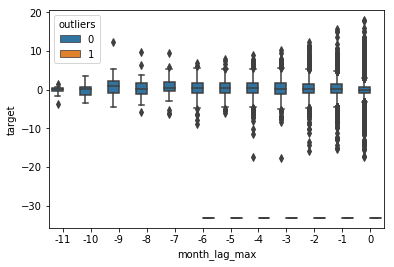

In [48]:
sns.boxplot(x='month_lag_max', y='target', hue='outliers', data=hist_train)
plt.show()

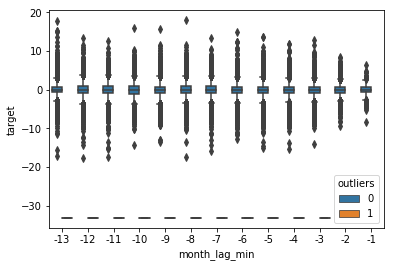

In [49]:
sns.boxplot(x='month_lag_min', y='target', hue='outliers', data=hist_train)
plt.show()

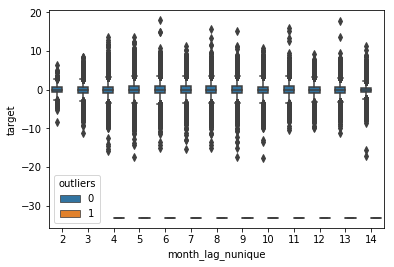

In [50]:
sns.boxplot(x='month_lag_nunique', y='target', hue='outliers', data=hist_train)
plt.show()

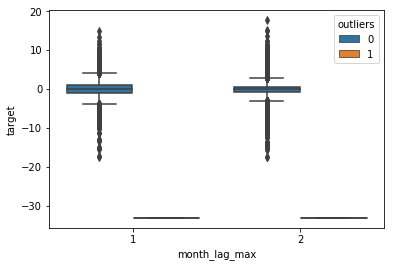

In [41]:
sns.boxplot(x='month_lag_max', y='target', hue='outliers', data=new_train)
plt.show()

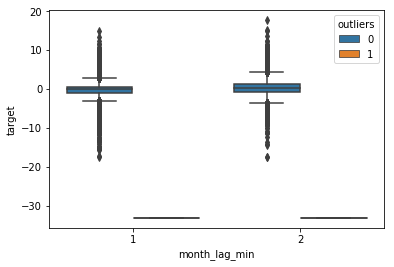

In [42]:
sns.boxplot(x='month_lag_min', y='target', hue='outliers', data=new_train)
plt.show()

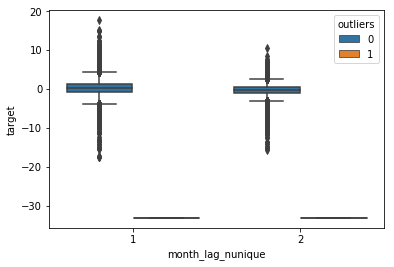

In [52]:
sns.boxplot(x='month_lag_nunique', y='target', hue='outliers', data=new_train)
plt.show()

In [56]:
historical_transactions[['purchase_date', 'month_lag', 'installments']]

,purchase_date,month_lag,installments
0,2017-06-25 15:33:07,-8,0
1,2017-07-15 12:10:45,-7,0
2,2017-08-09 22:04:29,-6,0
3,2017-09-02 10:06:26,-5,0
4,2017-03-10 01:14:19,-11,0
5,2018-02-24 08:45:05,0,0
6,2017-03-21 00:10:51,-11,0
7,2017-11-18 20:05:55,-3,0
8,2017-06-01 22:02:56,-8,0
9,2017-03-16 15:41:22,-11,0


In [58]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [136]:
historical_transactions = pd.read_csv('../input/historical_transactions.csv')

In [61]:
historical_transactions['purchase_amount'] = np.round(historical_transactions['purchase_amount'] / 0.00150265118 + 497.06,2)

In [60]:
grouped = historical_transactions.groupby('card_id').agg({
    'city_id': 'unique', 
    'merchant_category_id': 'unique',
    'month_lag': 'unique',
    'state_id': 'unique',
    'subsector_id': 'unique',
}).reset_index()

In [62]:
grouped.head()

,card_id,city_id,merchant_category_id,month_lag,state_id,subsector_id
0,C_ID_00007093c1,"[244, 76, -1, 333]","[307, 705, 108, 45, 755, 222, 373, 206, 422, 6...","[-4, -12, -9, -6, -7, -1, -11, -10, -8, -2, 0,...","[2, -1, 21]","[19, 33, 34, 18, 8, 21, 1, 27, 16, 29, 15, 12,..."
1,C_ID_0001238066,"[187, 314, 333, 69, 291, 149, 53, 213, -1, 19,...","[367, 705, 307, 278, 422, 80, 289, 561, 793, 5...","[-1, -3, -2, 0, -4, -5]","[15, 9, 20, -1, 21, 5]","[16, 33, 19, 37, 27, 7, 38, 3, 1, 12, 29, 34, ..."
2,C_ID_0001506ef0,"[137, 69, 147]","[422, 705, 813, 309, 879, 68, 87, 367, 179, 43...","[-2, -6, -1, -7, 0, -4, -12, -11, -9, -3, -5, ...","[19, 9]","[27, 33, 29, 21, 16, 8, 15, 34, 1, 25, 37, 19]"
3,C_ID_0001793786,"[179, 96, 87, 69, 322, 36, 204, 124, -1, 180]","[278, 884, 367, 111, 528, 703, 80, 195, 631, 7...","[-1, -5, -6, -4, -7, -3, 0, -2, -8, -9]","[-1, 24, 11, 9]","[37, 27, 16, 36, 25, 29, 34, 33, 41, 19, 7, 13..."
4,C_ID_000183fdda,"[69, 161, -1, 244, 302, 87, 109, 143, 344]","[879, 884, 769, 68, 367, 278, 690, 195, 734, 1...","[-5, -2, -4, 0, -1, -3, -6]","[9, 3, -1, 7, 11, 5, 18]","[29, 27, 32, 16, 37, 1, 34, 25, 36, 21, 33, 19..."


In [119]:
historical_transactions.nunique()

authorized_flag                2
card_id                   325540
city_id                      308
category_1                     2
installments                  15
category_3                     3
merchant_category_id         327
merchant_id               326311
month_lag                     14
purchase_amount           215014
purchase_date           16395300
category_2                     5
state_id                      25
subsector_id                  41
dtype: int64

In [117]:
train = pd.merge(train, grouped, on='card_id', how='left')

In [118]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers,city_id,merchant_category_id,month_lag,state_id,subsector_id
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,0,"[69, 231, 131, 181, 233, 334, 314]","[195, 278, 683, 309, 560, 80, 130, 454, 637, 5...","[-3, -7, -6, -2, -1, -5, 0, -4, -8]","[9, 5, 20]","[34, 37, 21, 41, 39, 25, 27, 7, 29, 33, 16, 18..."
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,0,"[69, 138, -1, 253, 213, 19, 279, 131, 159]","[68, 528, 80, 278, 879, 560, 307, 606, 87, 683...","[-4, -12, -11, -3, -1, 0, -5, -7, -6, -10, -8,...","[9, 15, -1]","[27, 25, 37, 29, 34, 19, 17, 16, 38, 15, 33, 3..."
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,0,"[143, 233, 19, 69, 209]","[705, 367, 511, 818, 793, 842, 80, 111]","[-6, -12, -9, -7, -11, -10, -4, -13, -2, -5, 0...","[5, 9]","[33, 16, 7, 12, 38, 37, 36]"
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,0,"[17, 88, -1, 69, 19, 212, 21]","[195, 683, 80, 651, 454, 278, 879, 386, 518, 4...","[-1, -4, -5, -2, 0, -3]","[22, 16, -1, 9, 4]","[34, 37, 2, 39, 29, 27, 15, 33, 22, 1, 3, 16, 30]"
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,0,"[-1, 17, 107, 69, 88, 143]","[879, 278, 656, 80, 705, 884, 528, 210, 480, 8...","[-2, 0, -3, -1]","[-1, 22, 4, 9, 16, 5]","[29, 37, 17, 33, 27, 25, 35, 24, 22, 34, 7, 39..."


In [120]:
train[train.outliers == 1]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers,city_id,merchant_category_id,month_lag,state_id,subsector_id
64,2017-09,C_ID_8186f3fcc1,3,1,1,-33.219281,1,"[149, -1, 304, 69, 288, 334, 56]","[705, 683, 690, 842, 561, 879, 560, 80, 307, 3...","[-1, -4, -5, -2, -3, 0]","[20, -1, 9]","[33, 34, 1, 37, 7, 29, 19, 2, 39, 16, 26, 18, ..."
92,2015-05,C_ID_b9379a30ea,3,3,1,-33.219281,1,[124],"[506, 198, 705, 178, 278, 437, 45, 367, 650, 307]","[-10, -4, -9, -3, -5, -8, -6]",[24],"[30, 10, 33, 29, 37, 15, 18, 16, 19]"
125,2015-10,C_ID_e9120f535c,3,3,1,-33.219281,1,"[149, 143, -1, 51]","[631, 307, 278, 427, 661, 489, 705, 842, 181, ...","[-6, 0, -3, -5, -4, -1, -2]","[20, 5, -1, 16]","[25, 19, 37, 27, 8, 16, 33, 7, -1, 1, 29, 34, 21]"
151,2017-03,C_ID_65715cb80d,4,2,0,-33.219281,1,[-1],"[879, 511]","[0, -3, -6, -1, -5, -4, -2, -7, -10, -9, -8]",[-1],"[29, 7]"
225,2017-01,C_ID_ae77d244b6,2,1,0,-33.219281,1,"[1, -1, 218, 8, 158, 69, 125]","[307, 706, 842, 761, 755, 705, 363, 511, 178, ...","[-4, -3, -11, -7, -8, -9, -10, -6, 0, -5, -2, ...","[12, -1, 15, 9, 16]","[19, 26, 37, 8, 33, 18, 7, 29, 16, 32, 34, 25,..."
248,2015-07,C_ID_c4262c902e,5,1,1,-33.219281,1,"[117, 19, -1]","[529, 884, 309, 451, 9, 356, 307, 437, 661, 83...","[-6, -2, -5, -4, -3, -1, 0]","[9, -1]","[20, 27, 21, 7, 19, 15, 8, 18]"
254,2017-03,C_ID_6a2c823e5f,2,1,0,-33.219281,1,"[331, -1, 69]","[307, 557, 879, 19, 511, 705, 755, 298]","[-2, -4, -3, -1, 0, -5]","[16, -1, 9]","[19, 29, 36, 7, 33, 8, 10]"
386,2017-06,C_ID_98e1cb10b6,2,3,0,-33.219281,1,"[20, -1, 69, 146, 211, 42]","[705, 755, 409, 19, 414, 836, 68, 879, 307, 69...","[0, -4, -3, -2, -1]","[19, -1, 9]","[33, 8, 29, 36, 5, 27, 19, 1, 34, 12, 32, 37, 31]"
467,2017-03,C_ID_eb8175721a,4,1,0,-33.219281,1,"[69, 13, -1, 19, 333, 231, 271]","[307, 705, 367, 661, 879, 839, 278, 80, 560, 6...","[-5, -4, 0, -3, -2, -8, -7, -6, -1]","[9, -1]","[19, 33, 16, 8, 29, 37, 34, 27, 18, 1, 4, 20, ..."
515,2016-04,C_ID_a2580006bf,4,2,0,-33.219281,1,[17],"[278, 307, 367, 705, 519, 683, 534, 560, 690, ...","[0, -4, -5, -2, -3]",[22],"[37, 19, 16, 33, 7, 34, 1, 30, 38, 27, 15, 36,..."


In [124]:
train['state_9'] = train.state_id.apply(lambda x: int(9 in x))

In [125]:
train.query('state_9 == 1 and outliers == 1')

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers,city_id,merchant_category_id,month_lag,state_id,subsector_id,state_9
64,2017-09,C_ID_8186f3fcc1,3,1,1,-33.219281,1,"[149, -1, 304, 69, 288, 334, 56]","[705, 683, 690, 842, 561, 879, 560, 80, 307, 3...","[-1, -4, -5, -2, -3, 0]","[20, -1, 9]","[33, 34, 1, 37, 7, 29, 19, 2, 39, 16, 26, 18, ...",1
225,2017-01,C_ID_ae77d244b6,2,1,0,-33.219281,1,"[1, -1, 218, 8, 158, 69, 125]","[307, 706, 842, 761, 755, 705, 363, 511, 178, ...","[-4, -3, -11, -7, -8, -9, -10, -6, 0, -5, -2, ...","[12, -1, 15, 9, 16]","[19, 26, 37, 8, 33, 18, 7, 29, 16, 32, 34, 25,...",1
248,2015-07,C_ID_c4262c902e,5,1,1,-33.219281,1,"[117, 19, -1]","[529, 884, 309, 451, 9, 356, 307, 437, 661, 83...","[-6, -2, -5, -4, -3, -1, 0]","[9, -1]","[20, 27, 21, 7, 19, 15, 8, 18]",1
254,2017-03,C_ID_6a2c823e5f,2,1,0,-33.219281,1,"[331, -1, 69]","[307, 557, 879, 19, 511, 705, 755, 298]","[-2, -4, -3, -1, 0, -5]","[16, -1, 9]","[19, 29, 36, 7, 33, 8, 10]",1
386,2017-06,C_ID_98e1cb10b6,2,3,0,-33.219281,1,"[20, -1, 69, 146, 211, 42]","[705, 755, 409, 19, 414, 836, 68, 879, 307, 69...","[0, -4, -3, -2, -1]","[19, -1, 9]","[33, 8, 29, 36, 5, 27, 19, 1, 34, 12, 32, 37, 31]",1
467,2017-03,C_ID_eb8175721a,4,1,0,-33.219281,1,"[69, 13, -1, 19, 333, 231, 271]","[307, 705, 367, 661, 879, 839, 278, 80, 560, 6...","[-5, -4, 0, -3, -2, -8, -7, -6, -1]","[9, -1]","[19, 33, 16, 8, 29, 37, 34, 27, 18, 1, 4, 20, ...",1
566,2016-12,C_ID_2e49ece8b1,2,3,0,-33.219281,1,"[69, -1, 19, 331]","[840, 884, 511, 108, 705, 45, 307, 80, 367, 69...","[-5, 0, -10, -4, -11, -9]","[9, -1, 16]","[20, 27, 7, 34, 33, 18, 19, 37, 16, 1, 9, 29, ...",1
578,2016-04,C_ID_7efe2311b7,2,2,0,-33.219281,1,"[21, 69, -1, 233, 19]","[557, 879, 80, 307, 771, 422, 419, 574, 367, 7...","[-4, -5, -1, 0, -2, -10, -3, -8, -9]","[9, -1]","[29, 37, 19, 31, 27, 1, 22, 16, 33, 18, 34]",1
761,2017-01,C_ID_e1844c986c,3,3,1,-33.219281,1,"[52, 200, 69]","[705, 278, 690, 683, 307, 373, 511, 842, 650, ...","[-5, 0, -8, -4, -2, -1, -3]","[4, 18, 9]","[33, 37, 1, 34, 19, 18, 7, 29, 32, 8, 16, 27]",1
810,2016-02,C_ID_237b80978f,3,3,1,-33.219281,1,"[158, 236, -1, 69, 253]","[884, 427, 367, 560, 384, 690, 68, 511, 879, 6...","[-3, -6, 0, -7, -2, -1, -5, -4]","[15, -1, 9]","[27, 16, 34, 7, 1, 29, 37, 33, 35]",1


In [126]:
train.query('state_9 == 1 and outliers == 0')

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers,city_id,merchant_category_id,month_lag,state_id,subsector_id,state_9
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,0,"[69, 231, 131, 181, 233, 334, 314]","[195, 278, 683, 309, 560, 80, 130, 454, 637, 5...","[-3, -7, -6, -2, -1, -5, 0, -4, -8]","[9, 5, 20]","[34, 37, 21, 41, 39, 25, 27, 7, 29, 33, 16, 18...",1
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,0,"[69, 138, -1, 253, 213, 19, 279, 131, 159]","[68, 528, 80, 278, 879, 560, 307, 606, 87, 683...","[-4, -12, -11, -3, -1, 0, -5, -7, -6, -10, -8,...","[9, 15, -1]","[27, 25, 37, 29, 34, 19, 17, 16, 38, 15, 33, 3...",1
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,0,"[143, 233, 19, 69, 209]","[705, 367, 511, 818, 793, 842, 80, 111]","[-6, -12, -9, -7, -11, -10, -4, -13, -2, -5, 0...","[5, 9]","[33, 16, 7, 12, 38, 37, 36]",1
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,0,"[17, 88, -1, 69, 19, 212, 21]","[195, 683, 80, 651, 454, 278, 879, 386, 518, 4...","[-1, -4, -5, -2, 0, -3]","[22, 16, -1, 9, 4]","[34, 37, 2, 39, 29, 27, 15, 33, 22, 1, 3, 16, 30]",1
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,0,"[-1, 17, 107, 69, 88, 143]","[879, 278, 656, 80, 705, 884, 528, 210, 480, 8...","[-2, 0, -3, -1]","[-1, 22, 4, 9, 16, 5]","[29, 37, 17, 33, 27, 25, 35, 24, 22, 34, 7, 39...",1
5,2016-09,C_ID_0894217f2f,4,2,0,0.871585,0,"[69, -1, 19, 143]","[422, 884, 68, 506, 172, 511, 518, 419, 793, 5...","[-5, -1, -6, 0, -3, -4, -2]","[9, -1, 5]","[27, 30, 38, 7, 1, 22, 41, 17]",1
6,2016-12,C_ID_7e63323c00,3,2,1,0.230129,0,"[160, 268, 169, 181, 69, 143]","[705, 367, 557, 273, 68, 884, 111, 80, 419, 50...","[-13, -1, -5, -11, -2, 0, -10, -12, -9, -8, -7...","[21, 20, 5, 9]","[33, 16, 29, 20, 27, 36, 37, 1, 30, 34, 17, 15]",1
7,2017-09,C_ID_dfa21fc124,3,2,1,2.135850,0,"[320, 69]","[80, 683, 879, 705, 307, 623, 360]","[-2, -3, 0, -1]","[13, 9]","[37, 34, 29, 33, 19, 4]",1
8,2017-08,C_ID_fe0fdac8ea,2,1,0,-0.065406,0,"[173, -1]","[705, 222, 879, 60]","[-6, -5, -3, -2, -4]","[9, -1]","[33, 21, 29, 13]",1
9,2016-08,C_ID_bf62c0b49d,2,2,0,0.300062,0,"[69, 88, 331, 32, 60, 143]","[879, 278, 531, 544, 80, 560, 690, 705, 68, 88...","[-4, -6, -3, -7, -5, -8, -1, -2, -10, -9, 0, -...","[9, 16, 5]","[29, 37, 27, 34, 1, 33, 16, 7, 36, 30, 15, 21, 4]",1


In [128]:
historical_transactions[historical_transactions.city_id == -1]['subsector_id'].unique()

array([34, 37, 15, 19, 18, 29, 22, 26,  8, 33, 27, 21,  3, 31,  7,  1, 12,
       16, 20, 35, 17, 36, 41, 25,  4,  5, 32, 30, 11,  9, 39, 40,  2, -1,
       10, 38, 13, 24, 23, 14])

In [129]:
historical_transactions[historical_transactions.subsector_id == -1]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
20076,Y,C_ID_9861d0fa05,-1,Y,1,B,-1,M_ID_49d4a8510e,-11,2.253887,2017-02-13 21:40:50,NaN,-1,-1
41469,Y,C_ID_28fa6e1b95,-1,Y,12,C,-1,M_ID_49d4a8510e,-11,2.713938,2017-03-17 12:44:36,NaN,-1,-1
44480,N,C_ID_c3efc5edf5,-1,Y,1,B,-1,M_ID_49d4a8510e,-5,-0.601151,2017-09-01 19:31:40,NaN,-1,-1
57134,Y,C_ID_deda0cca28,-1,Y,1,B,-1,M_ID_49d4a8510e,-5,-0.673278,2017-09-22 13:24:49,NaN,-1,-1
71892,N,C_ID_9315f3a209,-1,Y,1,B,-1,M_ID_49d4a8510e,-7,-0.601151,2017-07-17 15:45:00,NaN,-1,-1
71995,N,C_ID_9315f3a209,-1,Y,1,B,-1,M_ID_49d4a8510e,-7,-0.601151,2017-07-17 15:44:28,NaN,-1,-1
85886,Y,C_ID_99c391a674,-1,Y,3,C,-1,M_ID_49d4a8510e,-4,-0.451817,2017-10-10 01:31:19,NaN,-1,-1
103122,Y,C_ID_b7cb3398bb,-1,Y,1,B,-1,M_ID_49d4a8510e,-5,-0.131527,2017-09-04 15:06:54,NaN,-1,-1
130876,N,C_ID_cbad782b86,-1,Y,12,C,-1,M_ID_49d4a8510e,-5,0.454732,2017-09-04 12:12:35,NaN,-1,-1
130910,Y,C_ID_cbad782b86,-1,Y,12,C,-1,M_ID_49d4a8510e,-6,0.454732,2017-08-10 22:13:21,NaN,-1,-1


In [130]:
historical_transactions['city_minus_one'] = historical_transactions['city_id'].apply(lambda x: np.where(x == -1, 1, 0))
historical_transactions['merchant_category_minus_one'] = historical_transactions['merchant_category_id'].apply(lambda x: np.where(x == -1, 1, 0))
historical_transactions['state_minus_one'] = historical_transactions['state_id'].apply(lambda x: np.where(x == -1, 1, 0))
historical_transactions['subsector_minus_one'] = historical_transactions['subsector_id'].apply(lambda x: np.where(x == -1, 1, 0))

In [132]:
sum(historical_transactions['city_minus_one'] != historical_transactions['merchant_category_minus_one']) 

2476456

In [133]:
historical_transactions[['city_minus_one', 'merchant_category_minus_one', 'state_minus_one', 'subsector_minus_one']]

,city_minus_one,merchant_category_minus_one,state_minus_one,subsector_minus_one
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,0,0,0
9,0,0,0,0


In [134]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,city_minus_one,merchant_category_minus_one,state_minus_one,subsector_minus_one
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,0,0,0,0
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,0,0,0,0
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,0,0,0,0
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,0,0,0,0
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,0,0,0,0


In [137]:
grouped = historical_transactions.groupby('card_id')['purchase_date'].min().reset_index()

In [142]:
grouped.rename(columns={'purchase_date': 'purchase_date_min'}, inplace=True)

In [144]:
historical_transactions = pd.merge(historical_transactions, grouped, on='card_id', how='left')

In [145]:
historical_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'])
historical_transactions['purchase_date_min'] = pd.to_datetime(historical_transactions['purchase_date_min'])

In [148]:
historical_transactions['days'] = (historical_transactions['purchase_date'].dt.date - historical_transactions['purchase_date_min'].dt.date).dt.days

In [149]:
historical_transactions['days'].unique()

array([156, 176, 201, 225,  49, 400,  60, 302, 132,  55, 109, 384, 139,
       175, 277, 145, 383, 168, 353, 203, 222, 162, 106,   0, 402,  99,
       154, 197, 403, 216, 248, 228, 199, 239, 273, 232, 217, 272,  84,
       174, 283, 245, 260, 214, 221, 238, 240, 142,  53, 399,  77,  25,
       385, 123, 254, 279, 258, 391,  47, 223, 252,  42,  51, 144, 151,
       394, 113, 231, 269, 246, 401, 108,  83, 270, 328, 166, 382, 111,
       236, 107,  67,  98, 380, 196,  54, 227, 259,  95, 127, 130, 117,
       128, 193, 159,  26, 202,  56, 218, 257, 250, 253, 125, 263, 244,
        18,  87, 235, 398, 396, 126,  79, 153, 131, 206, 274, 133, 386,
       271, 388, 393,  48, 397, 242,  76,  91,  65,  50, 220, 213, 265,
       211, 192, 195, 404, 251, 326, 164, 212, 264, 224, 278, 207,  64,
        71, 169, 121,  61, 208,  81, 140, 204, 241, 275, 122,  63,  70,
       141,  68, 261, 215,  96, 229, 160, 395, 110, 237, 230, 173, 210,
       262, 387, 200, 249, 243, 172, 171, 389, 165, 105, 390, 36

In [164]:
historical_transactions['round_days'] = (np.ceil(historical_transactions['days'] // 10) * 10).astype(int)

In [165]:
historical_transactions['round_days'].unique()

array([150, 170, 200, 220,  40, 400,  60, 300, 130,  50, 100, 380, 270,
       140, 160, 350,   0,  90, 190, 210, 240, 230,  80, 280, 260, 390,
        70,  20, 120, 250, 110, 320,  10, 360,  30, 180, 340, 310, 330,
       290, 370, 420, 410])

In [166]:
historical_transactions['agg_flag'] = 1

In [167]:
pt = pd.pivot_table(historical_transactions, index='card_id', columns=['round_days'], values=['agg_flag'], aggfunc='count').reset_index()

In [168]:
pt.columns = [f'{c[0]}_{c[1]}'.strip('_') for c in pt.columns]

In [176]:
pt.add_prefix('hist_').columns

Index(['hist_card_id', 'hist_agg_flag_0', 'hist_agg_flag_10',
       'hist_agg_flag_20', 'hist_agg_flag_30', 'hist_agg_flag_40',
       'hist_agg_flag_50', 'hist_agg_flag_60', 'hist_agg_flag_70',
       'hist_agg_flag_80', 'hist_agg_flag_90', 'hist_agg_flag_100',
       'hist_agg_flag_110', 'hist_agg_flag_120', 'hist_agg_flag_130',
       'hist_agg_flag_140', 'hist_agg_flag_150', 'hist_agg_flag_160',
       'hist_agg_flag_170', 'hist_agg_flag_180', 'hist_agg_flag_190',
       'hist_agg_flag_200', 'hist_agg_flag_210', 'hist_agg_flag_220',
       'hist_agg_flag_230', 'hist_agg_flag_240', 'hist_agg_flag_250',
       'hist_agg_flag_260', 'hist_agg_flag_270', 'hist_agg_flag_280',
       'hist_agg_flag_290', 'hist_agg_flag_300', 'hist_agg_flag_310',
       'hist_agg_flag_320', 'hist_agg_flag_330', 'hist_agg_flag_340',
       'hist_agg_flag_350', 'hist_agg_flag_360', 'hist_agg_flag_370',
       'hist_agg_flag_380', 'hist_agg_flag_390', 'hist_agg_flag_400',
       'hist_agg_flag_410', 'hist_ag

In [175]:
pt[pt.card_id.isin(train.query('outliers == 1')['card_id'])]

,card_id,agg_flag_0,agg_flag_10,agg_flag_20,agg_flag_30,agg_flag_40,agg_flag_50,agg_flag_60,agg_flag_70,agg_flag_80,...,agg_flag_330,agg_flag_340,agg_flag_350,agg_flag_360,agg_flag_370,agg_flag_380,agg_flag_390,agg_flag_400,agg_flag_410,agg_flag_420
127,C_ID_001982552a,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,C_ID_0029d52418,1.0,NaN,13.0,17.0,5.0,14.0,1.0,5.0,2.0,...,2.0,13.0,12.0,9.0,28.0,26.0,6.0,NaN,NaN,NaN
358,C_ID_0046b2b355,1.0,NaN,1.0,2.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407,C_ID_0050fc55c0,1.0,NaN,3.0,1.0,NaN,1.0,4.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430,C_ID_005799985c,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526,C_ID_006b9a7fed,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,12.0,14.0,18.0,21.0,15.0,13.0,4.0,11.0,12.0,2.0
670,C_ID_0089a52031,5.0,3.0,1.0,NaN,NaN,1.0,3.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
910,C_ID_00b754135e,4.0,1.0,9.0,5.0,1.0,2.0,2.0,NaN,NaN,...,NaN,NaN,NaN,3.0,1.0,NaN,3.0,NaN,5.0,NaN
987,C_ID_00c41e4187,6.0,10.0,5.0,1.0,6.0,5.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1139,C_ID_00e66e8ace,3.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,...,NaN,NaN,2.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
pt

In [173]:
train[train['card_id'] == "C_ID_0004587331"]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,outliers,city_id,merchant_category_id,month_lag,state_id,subsector_id,state_9


In [2]:
historical_transactions = pd.read_csv('../input/historical_transactions.csv')

In [3]:
historical_transactions['month_lag_x_installments'] = historical_transactions['month_lag'] - historical_transactions['installments']

In [8]:
historical_transactions['purchase_amount_new'] = np.round(historical_transactions['purchase_amount'] / 0.00150265118 + 497.06,2)

In [9]:
historical_transactions.loc[historical_transactions['installments'] == -1, 'purchase_amount_new']

885           299.00
914           235.00
936           180.49
941           130.00
965           420.60
992           777.77
1003          138.50
1031           90.00
1035          150.00
2329          110.00
6369          177.77
6478          109.00
6501          109.00
6586          279.99
6602          162.70
6633         1969.00
11649         548.00
11652        1763.00
11665        9265.00
11778         920.00
11971         320.00
12895         896.00
12904         392.04
13372         469.98
13503         228.00
13509         437.40
13521         733.80
13529       10600.00
13563         356.50
13577         138.40
              ...   
29111111     3384.40
29111149      329.99
29111203      220.00
29111265      735.40
29111279      500.00
29111349      239.00
29111505      500.00
29111533      189.00
29111565      808.03
29111566      515.22
29111567      653.28
29111595       96.00
29111624     2199.00
29111659      315.00
29111667      900.00
29111702      119.00
29111727     

In [31]:
historical_transactions.loc[historical_transactions['installments'] == 999, ['purchase_amount_new', 'card_id']].sort_values('card_id')

,purchase_amount_new,card_id
10482837,3800.00,C_ID_02bd1c4210
28996126,961.00,C_ID_05240c2353
21241132,1187.00,C_ID_06fca19c8e
10410638,1500.00,C_ID_094bb1b704
8549841,1449.60,C_ID_09dcde8f3c
28258830,82.00,C_ID_0a0fcf2fc3
2063505,324.60,C_ID_0a3724504a
21572523,5400.00,C_ID_0ba083756a
27078432,176.97,C_ID_0e00a3c5e2
8382138,279.99,C_ID_0f1f3c5b68


In [33]:
historical_transactions.loc[historical_transactions['card_id'] == 'C_ID_02bd1c4210', 'purchase_amount_new'].max()

6000.0

In [18]:
from collections import Counter
cnt = Counter(historical_transactions.loc[historical_transactions['installments'] == -1, 'card_id'].values)

In [19]:
cnt.most_common()

[('C_ID_3423ee4510', 58),
 ('C_ID_a5e7401c28', 47),
 ('C_ID_9193ff0ed3', 46),
 ('C_ID_f408490781', 45),
 ('C_ID_195a8a9e47', 42),
 ('C_ID_695671db99', 36),
 ('C_ID_a35a5de07a', 36),
 ('C_ID_ab83ffccde', 32),
 ('C_ID_91c402de95', 31),
 ('C_ID_9c32b9244e', 30),
 ('C_ID_5bad4ae043', 27),
 ('C_ID_32b4aec23a', 27),
 ('C_ID_d846954985', 26),
 ('C_ID_a61acce4d8', 26),
 ('C_ID_ff2455a117', 26),
 ('C_ID_580c4d9f57', 26),
 ('C_ID_db09991fae', 25),
 ('C_ID_29264459a2', 25),
 ('C_ID_e13bd5e10c', 25),
 ('C_ID_502c589ce2', 24),
 ('C_ID_5d53d89589', 24),
 ('C_ID_a558e907a9', 24),
 ('C_ID_c15714daf0', 24),
 ('C_ID_1c856df18a', 23),
 ('C_ID_3e8673c112', 23),
 ('C_ID_e6877d8059', 23),
 ('C_ID_046484476e', 23),
 ('C_ID_633ea6948f', 23),
 ('C_ID_b61332f48e', 23),
 ('C_ID_f3c622072b', 23),
 ('C_ID_fbe32697a7', 23),
 ('C_ID_a71f0e0f1e', 23),
 ('C_ID_38bb0029f1', 23),
 ('C_ID_2fa12ecb64', 22),
 ('C_ID_2f372f81d2', 22),
 ('C_ID_8c12d0aeed', 22),
 ('C_ID_68ca79e82d', 22),
 ('C_ID_dc20bb6ffb', 22),
 ('C_ID_b04d

In [24]:
historical_transactions.loc[historical_transactions['card_id'] == 'C_ID_3423ee4510', 'installments'].median()

2.0

In [25]:
historical_transactions.loc[historical_transactions['card_id'] == 'C_ID_a5e7401c28', 'installments'].median()

1.0

In [35]:
historical_transactions.loc[historical_transactions['card_id'] == 'C_ID_a5e7401c28', ['installments', 'merchant_id', 'purchase_amount_new']]

,installments,merchant_id,purchase_amount_new
15239245,6,M_ID_9da7cb493e,795.40
15239246,1,M_ID_3df6c7b4c0,11.05
15239247,3,M_ID_121f51a6d0,801.59
15239248,1,M_ID_bbf00ddc42,18.40
15239249,-1,M_ID_bbf00ddc42,690.17
15239250,-1,M_ID_bbf00ddc42,610.51
15239251,0,M_ID_00a6ca8a8a,70.00
15239252,1,M_ID_bb3be8bb25,112.11
15239253,6,M_ID_9da7cb493e,6528.00
15239254,1,M_ID_9d6354ebf2,40.63


In [34]:
historical_transactions.loc[historical_transactions['card_id'] == 'C_ID_3423ee4510', ['installments', 'merchant_id', 'purchase_amount_new']]

,installments,merchant_id,purchase_amount_new
20788466,2,M_ID_b3ab114fb9,150.01
20788467,-1,M_ID_b3ab114fb9,105.00
20788468,2,M_ID_b3ab114fb9,220.00
20788469,-1,M_ID_b3ab114fb9,120.00
20788470,-1,M_ID_b3ab114fb9,130.00
20788471,-1,M_ID_b3ab114fb9,148.00
20788472,-1,M_ID_b3ab114fb9,300.00
20788473,-1,M_ID_b3ab114fb9,200.63
20788474,-1,M_ID_b3ab114fb9,132.00
20788475,2,M_ID_b3ab114fb9,50.00


In [66]:
historical_transactions['merchant_id'].fillna('ONLINE', inplace=True)

In [77]:
t = historical_transactions.query('installments == -1').groupby('card_id')['merchant_id'].unique().reset_index()

In [78]:
t.head()

,card_id,merchant_id
0,C_ID_0001238066,"[M_ID_3f35ef9a50, M_ID_970d4d00da, M_ID_40d7b1..."
1,C_ID_000183fdda,"[M_ID_f4e377b35d, M_ID_4b99ea1c74, M_ID_67894e..."
2,C_ID_0002709b5a,[M_ID_5bb84e5819]
3,C_ID_0003be3c83,[M_ID_d0146c836a]
4,C_ID_00042d509c,"[M_ID_f9d492675f, M_ID_bced6871aa]"


In [91]:
card_ids = t['card_id'].unique()
merchant_idss = t['merchant_id']

In [90]:
for card_id in tqdm(cards_ids):
    installments_median = historical_transactions.loc[historical_transactions['card_id'] == card_id, 'installments'].median()
    historical_transactions.loc[
        (historical_transactions['card_id'] == card_id) & (historical_transactions['installments'] == -1),
        'installments'] = installments_median


  0%|          | 50/178159 [03:04<182:28:08,  3.69s/it]

KeyboardInterrupt: 

In [ ]:
from multiprocessing import cpu_count, Pool

def fillna_installments(card_id):
    installments_median = historical_transactions.loc[historical_transactions['card_id'] == card_id, 'installments'].median()
    historical_transactions.loc[historical_transactions['card_id'] == card_id,'installments'].replace(-1, installments_median, inplace=True)
    
    return
    
pool = Pool(4)
pool.map(fillna_installments, card_ids)
pool.close()

In [94]:
historical_transactions.to_csv(f'../remove_outlier_data/historical_transactions_fill_installments.csv', index=False)

In [97]:
historical_transactions.query('installments == -1')

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_lag_x_installments,purchase_amount_new
17822,N,C_ID_d26b4291db,140,N,-1.0,NaN,333,M_ID_7f3725adb5,-3,-0.211964,2017-11-10 00:00:00,1.0,9,10,-2,356.00
18057,Y,C_ID_e995d051ae,137,N,-1.0,NaN,771,M_ID_a514e2b187,-2,-0.660505,2017-12-09 19:46:06,3.0,19,31,-1,57.50
18137,Y,C_ID_e995d051ae,137,N,-1.0,NaN,506,M_ID_ba2729a5ea,-3,-0.028641,2017-11-24 00:00:00,3.0,19,30,-2,478.00
18169,Y,C_ID_e995d051ae,137,N,-1.0,NaN,506,M_ID_ba2729a5ea,-3,-0.028641,2017-11-05 00:00:00,3.0,19,30,-2,478.00
18175,Y,C_ID_e995d051ae,137,N,-1.0,NaN,506,M_ID_cf37dd7fee,-3,-0.446528,2017-11-24 00:00:00,3.0,19,30,-2,199.90
18190,Y,C_ID_e995d051ae,137,N,-1.0,NaN,434,M_ID_82644c6c6b,-2,-0.234955,2017-12-09 20:13:00,3.0,19,32,-1,340.70
18682,Y,C_ID_e6c5c7f7a7,110,N,-1.0,NaN,369,M_ID_8219b719d0,-2,-0.573397,2017-12-15 16:42:38,1.0,16,27,-1,115.47
19147,Y,C_ID_062c6dda0f,251,N,-1.0,NaN,34,ONLINE,0,-0.521660,2018-02-02 19:27:02,3.0,8,38,1,149.90
19155,Y,C_ID_062c6dda0f,251,N,-1.0,NaN,87,M_ID_bc03a7deac,0,-0.416926,2018-02-02 19:39:39,3.0,8,27,1,219.60
20341,Y,C_ID_89445651cf,51,N,-1.0,NaN,434,M_ID_7ba5cadfc3,-2,0.269786,2017-10-27 00:00:00,1.0,16,32,-1,676.60


In [99]:
installments_median = historical_transactions.loc[historical_transactions['card_id'] == card_id, 'installments'].median()
historical_transactions.loc[(historical_transactions['card_id'] == card_id) & (historical_transactions['installments'] == -1), 'installments'] = installments_median  

In [106]:
historical_transactions.loc[historical_transactions['card_id'] == card_id,'installments'].replace(-1, installments_median, inplace=True)

In [108]:
historical_transactions.loc[historical_transactions['card_id'] == card_id,'installments']

17725    3.0
17726    1.0
17727    1.0
17728    3.0
17729    3.0
17730    1.0
17731    3.0
17732    1.0
17733    1.0
17734    3.0
17735    1.0
17736    1.0
17737    1.0
17738    1.0
17739    1.0
17740    1.0
17741    1.0
17742    1.0
17743    1.0
17744    1.0
17745    1.0
17746    1.0
17747    1.0
17748    3.0
17749    1.0
17750    1.0
17751    1.0
17752    1.0
17753    3.0
17754    1.0
        ... 
17873    1.0
17874    1.0
17875    1.0
17876    1.0
17877    1.0
17878    1.0
17879    1.0
17880    1.0
17881    1.0
17882    1.0
17883    1.0
17884    1.0
17885    1.0
17886    1.0
17887    1.0
17888    1.0
17889    1.0
17890    1.0
17891    1.0
17892    1.0
17893    1.0
17894    1.0
17895    1.0
17896    1.0
17897    1.0
17898    1.0
17899    1.0
17900    1.0
17901    1.0
17902    1.0
Name: installments, Length: 178, dtype: float64

In [103]:
installments_median = historical_transactions.loc[historical_transactions['card_id'] == card_id, 'installments'].median()

In [104]:
installments_median

1.0